# Plotting training results of DEPT paper

This notebook serves as a visualization tool for the training results of the **DEPT** paper results.
It reads the metric from the training curves directly from Wandb and collect them in `pandas` data frames ready to be analyzed and plotted.

In [33]:
# Imports
from logging import INFO, ERROR
from typing import Any
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.style as mplstyle
import wandb
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator
import enum
from flwr.common import log

# Use custom fonts
USE_CUSTOM_FONTS = False

# Load style sheet
STYLE_SHEET_PATH = "/Users/lorenzosani/Repositories/flower_llm/notebooks/camlsys_matplotlib_style_conference.mplstyle"

if USE_CUSTOM_FONTS:
    matplotlib.use("pgf")
    STYLE_SHEET_PATH = "/Users/lorenzosani/Repositories/flower_llm/notebooks/camlsys_matplotlib_style.mplstyle"
    # STYLE_SHEET_PATH = "/Users/lorenzosani/Repositories/flower_llm/notebooks/camlsys_matplotlib_style_inv.mplstyle"

plt.style.use(STYLE_SHEET_PATH)

# Colors
color_palette = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# Line styles
line_styles = [
    (0, ()),  # Solid
    (0, (1, 1)),  # Dotted
    (0, (5, 5)),  # Dashed
    (0, (3, 5, 1, 5)),  # Dashdotted
    (0, (3, 5, 1, 5, 1, 5)),  # Dashdotdotted
    (0, (1, 10)),  # Loosely dotted
    (0, (1, 1)),  # Densely dotted
    (5, (10, 3)),  # Long dash with offset
    (0, (5, 10)),  # Loosely dashed
    (0, (5, 1)),  # Densely dashed
    (0, (3, 10, 1, 10)),  # Loosely dashdotted
    (0, (3, 1, 1, 1)),  # Densely dashdotted
    (0, (3, 10, 1, 10, 1, 10)),  # Loosely dashdotdotted
    (0, (3, 1, 1, 1, 1, 1)),  # Densely dashdotdotted
]
# Patterns for bar plots
patterns = ["|", "\\", "/", "+", "-", ".", "*", "x", "o", "O"]
mplstyle.use("fast")
# Figure size
fig_size = (5, 4)  # (4, 3)
fig_size1 = (5, 4)  # (8, 3)
fig_size2 = (5, 4)  # (8, 3)

In [34]:
class CentSuffix(str, enum.Enum):
    """Enum class for suffixes of centralized runs."""

    CENTRALIZED = "_centralised"
    CLIENT_0 = "_client_0"
    NONE = ""

In [35]:
class AxisLabels(str, enum.Enum):
    """Enum class for x- or y-axis labels."""

    SEQ_STEPS = r"\textbf{Sequential Steps}"
    FED_ROUND = r"\textbf{Federated Round}"
    PPL = r"\textbf{Perplexity}"
    ACT = r"\textbf{Activations (L2)}"
    IMP = r"\textbf{Perplexity Ratio}"
    L2 = r"\textbf{Norm Model\\Parameters (L2)}"

In [36]:
class PlottingCosmetics(str, enum.Enum):
    """Enum class for plotting cosmetics constants."""

    UPPER_RIGHT_POS = "upper right"
    UPPER_CENTER_POS = "upper center"

In [37]:
class MethodsNames(str, enum.Enum):
    """Enum class for plotted methods names (LaTeX-ready)."""

    TEMPERATURE_0_3 = r"\textbf{STD ($\boldsymbol{\tau=}\mathbf{0.3}$)}"
    PROPORTIONAL = r"\textbf{STD ($\boldsymbol{\tau=}\mathbf{1}$)}"
    ACT = r"\textbf{ACT}"
    DEPT_AVG = r"\textbf{DEPT-AVG}"
    UNIFORM = r"\textbf{STD ($\boldsymbol{\tau=}\mathbf{0}$)}"

In [38]:
class MetricsNames(str, enum.Enum):
    """Enum class for plotted metrics names."""

    ACT_OUTPUT = "activations/average/max/full_model_output"
    L2_NORM_P_GLOBAL = "l2_norm/param/global"
    TRAIN_PPL = "metrics/train/LanguagePerplexity"
    VAL_PPL = "ValLanguagePerplexity"
    IMPROVEMENT_RATIO = "improvement_ratio"

In [39]:
# Set the run_id to be retrieved
run_id_dict = {
    "fed-1B-short": [
        ("fed-1B-20240322_221900-fix-nesto", 8, True, False),
        # ("fed-1B-20240509_061535", 8, True, False),
        ("fed-1B-20240510_074507", 8, True, False),
    ],
    "fed-1B-long": [
        ("fed-1B-20240314_232607", 8, True, False),
    ],
    "cen-1B": [
        ("centralised-1B-20240229_104204", CentSuffix.NONE),
    ],
    "fed-350M": [
        ("fed-350M-20240506_204125", 8, True, False),
        ("fed-350M-20240505_100605", 8, True, False),
    ],
    "cen-350M": [
        ("centralised-350M-20240305_191112", CentSuffix),
    ],
    "fed-160M": [],
    "cen-160M": [],
    "fed-125M": [
        ("fed-125M-20240502_203012-continue-3", 8, True, False),
        ("fed-125M-20240502_203012", 8, True, False),
    ],
    "cen-125M": [("centralised-125M-20240510_095447_client_0", CentSuffix.CLIENT_0)],
    "fed-75M": [("fed-75M-20240506_234900", 8, True, False)],
    "cen-75M": [("centralised-75M-20240508_212653", CentSuffix.CLIENT_0)],
    "fed-pile-75M-8": [
        ("pile-75M-final-20240605_133225-con", 8, True, False),
        ("pile-75M-final-20240605_133225", 8, True, False),
    ],
    "fed-pile-125M-8": [
        ("pile-125M-final-20240608_174142", 8, True, False),
    ],
    # DEPT section
    "mclr_cen-pile-75M-8": [("pile-75M-cent-20240607_105615", CentSuffix.CENTRALIZED)],
    "mclr_cen-pile-125M-8": [
        ("pile-125M-cent-20240607_225637", CentSuffix.CENTRALIZED)
    ],
    "mclr_cen-pile-125M-16_balanced": [
        ("centB-125M-p-20240919_190940", CentSuffix.CENTRALIZED)
    ],
    "mclr_cen-pile-125M-16_unbalanced": [
        ("centB-125M-p-20240919_190940", CentSuffix.CENTRALIZED)
    ],
    "mclr_cen-pile-350M-16_balanced": [
        ("centB-350M-p-20240921_082028", CentSuffix.CENTRALIZED.value)
    ],
    "mclr_cen-pile-350M-16_unbalanced": [
        ("centUB-350M-p-20240922_095350", CentSuffix.CENTRALIZED.value)
    ],
    "mclr_matrix-pile-350M": [("matrix-350M-p-20240825_231845", 16, True, False)],
    "mclr_full-pile-350M": [("full-350M-p-20240825_tle", 16, True, False)],
    "mclr_pers-350M-p-20240825_232233": [
        ("pers-350M-p-20240825_232233", 16, True, False)
    ],
    "mclr_matrix-mc4-125M": [("matrix-125M-mc4-20240912-tle", 8, True, False)],
    "mclr_full-mc4-125M": [("full-125M-mc4-20240912-tle", 8, True, False)],
    "mclr_pers-125M-p-20240825_232233": [
        ("pers-125M-mc4-20240912-tle", 8, True, False)
    ],
    "mclr_cen-mc4-125M-8_balanced": [
        ("centB-125M-mc4-20240918_101655", CentSuffix.CENTRALIZED.value)
    ],
    "mclr_cen-mc4-125M-8_unbalanced": [
        ("centUB-125M-mc4-20240918_151230", CentSuffix.CENTRALIZED.value)
    ],
    "mclr_cen-mc4-125M-8_t03": [
        ("centT03-125M-mc4-20240918_213225", CentSuffix.CENTRALIZED.value)
    ],
    "fed-partial-75M-4_64": [("partial-75M-20240610_135450", 64, True, False)],
    "cen-partial-75M-4_64": [("centralised-75M-20240508_212653", CentSuffix.CLIENT_0)],
    "fed-partial-125M-4_64": [("partial-125M-20240611_011620", 64, True, False)],
    "cen-partial-125M-4_64": [
        ("centralised-125M-20240510_095447_client_0", CentSuffix.CLIENT_0)
    ],
    "matrix-125M-20240823-tle": [("matrix-125M-20240823-tle", 16, True, False)],
    "full-125M-20240823_125915": [("full-125M-20240823_125915", 16, True, False)],
    "centB-125M-20240907_115804": [
        ("centB-125M-20240907_115804", CentSuffix.CENTRALIZED.value)
    ],
}

In [40]:
# Server metrics columns
server_metrics_columns = [
    # Train-specific metrics
    "LanguageCrossEntropy",
    "LanguagePerplexity",
    # Val-specific metrics
    "ValLanguageCrossEntropy",
    MetricsNames.VAL_PPL,
    # Wandb internals
    "_runtime",
    "_step",
    "_timestamp",
    # Client-side bookkeeping
    "client/eval_init_time",
    "client/eval_metrics_collection_time",
    "client/eval_time",
    "client/eval_trainer_closing_time",
    "client/fit_get_parameters_time",
    "client/fit_init_time",
    "client/fit_metrics_collection_time",
    "client/fit_time",
    "client/fit_trainer_closing_time",
    # Client-side metrics
    "client/l2_norm_pseudo_gradient",
    "client_state_acc",
    "distributed_loss",
    # Node-side bookkeeping
    "node_eval_time_s",
    "node_training_time_s",
    # Server-side bookkeeping
    "server/evaluate_round_time",
    "server/evaluate_time",
    "server/first_check_nm_time",
    "server/fit_round_time",
    "server/round_time",
    "server/second_check_nm_time",
    # Server-side computed norms
    "server/l2_norm_fedavg_result",
    "server/l2_norm_model",
    "server/l2_norm_momentum_vector",
    "server/l2_norm_pseudo_gradient",
    # Step
    "step",
    # Worker-side bookkeeping
    "worker/partial_aggregation_time",
]

In [41]:
# Client metrics columns
client_metrics_columns = [
    # Wandb internals
    "_runtime",
    "_step",
    "_timestamp",
    # Activation norms
    "activations/l2_norm/full_model_input",
    "activations/l2_norm/full_model_output",
    MetricsNames.ACT_OUTPUT,
    # CID
    "client_id",
    # Momentum, gradient and model norms
    "l2_norm/grad/global",
    "l2_norm/moment/global",
    MetricsNames.L2_NORM_P_GLOBAL,
    "l2_norm/update/global",
    # Train loss
    "loss/train/total",
    # LR
    "lr-DecoupledAdamW/group0",
    # Memory metrics
    "memory/alloc_retries",
    "memory/current_active_mem",
    "memory/current_allocated_mem",
    "memory/current_inactive_mem",
    "memory/current_reserved_mem",
    "memory/peak_active_mem",
    "memory/peak_allocated_mem",
    "memory/peak_inactive_mem",
    "memory/peak_reserved_mem",
    "metrics/train/LanguageCrossEntropy",
    MetricsNames.TRAIN_PPL,
    # Step
    "step",
    # Throughput metrics
    "throughput/batches_per_sec",
    "throughput/device/batches_per_sec",
    "throughput/device/flops_per_sec",
    "throughput/device/mfu",
    "throughput/device/samples_per_sec",
    "throughput/device/tokens_per_sec",
    "throughput/flops_per_sec",
    "throughput/samples_per_sec",
    "throughput/tokens_per_sec",
    # Time metrics
    "time/batch",
    "time/batch_in_epoch",
    "time/epoch",
    "time/remaining_estimate",
    "time/sample",
    "time/sample_in_epoch",
    "time/token",
    "time/token_in_epoch",
    "time/total",
    "time/train",
    "time/val",
    # Microbatch size
    "trainer/device_train_microbatch_size",
]

In [42]:
x_lim: tuple[float, float] | None = None
perplexity_y_lim: dict[str, float] | None = {"top": 225, "bottom": 0}
norm_y_lim: dict[str, float] | None = {"bottom": 300, "top": 900}
momentum_y_lim: dict[str, float] | None = {"bottom": 300, "top": 900}
grad_y_lim: dict[str, float] | None = {"bottom": 0, "top": 125}
grad_client_y_lim: dict[str, float] | None = {"bottom": 0, "top": 1.6}
lr_y_lim: dict[str, float] | None = None
act_out_y_lim: dict[str, float] | None = None
act_out_y_lim: dict[str, float] | None = {"bottom": 0, "top": 1.3 * 1e7}
perplexity_legend_kwargs: dict[str, Any] | None = None
l2_gradient_legend_kwargs: dict[str, Any] | None = None

In [43]:
def download_metrics(
    run_id: str, n_clients: int, drop_layers: bool = True, use_server_name: bool = False
) -> tuple[pd.DataFrame, pd.DataFrame, list[pd.DataFrame]]:
    """Download all the metrics from given run_id using Wandb API."""
    # Initialize the wandb API
    api = wandb.Api(timeout=100)
    # Get the run object
    server_run = (
        api.run(f"camlsys/pollen-llm/{run_id}_server")
        if use_server_name
        else api.run(f"camlsys/pollen-llm/{run_id}")
    )
    # Get the metrics
    server_metrics = server_run.scan_history()
    # Convert the metrics to a pandas data frame
    server_metrics_df = pd.DataFrame(server_metrics)
    # Drop the layers columns if needed
    if drop_layers:
        layer_columns = [col for col in server_metrics_df.columns if "layer" in col]
        server_metrics_df = server_metrics_df.drop(columns=layer_columns)
    # Add the `step` column based on the index
    server_metrics_df["step"] = server_metrics_df.index
    # Get clients metrics
    clients_metrics_df_list: list[pd.DataFrame] = []

    for i in range(n_clients):
        try:
            # Get the run object

            client_run = (
                api.run(f"camlsys/pollen-llm/{run_id}_client_{i}")
                if (
                    run_id
                    not in {
                        "pile-75M-final-20240605_133225",
                        "partial-75M-20240605_133326",
                    }
                )
                else api.run(f"camlsys/pollen-llm/{run_id}client_{i}")
            )
            # Get the metrics
            client_metrics = client_run.scan_history()
            # Convert the metrics to a pandas data frame
            client_metrics_df = pd.DataFrame(client_metrics)
            # Drop the layers columns if needed
            if drop_layers:
                layer_columns = [
                    col for col in client_metrics_df.columns if "layer" in col
                ]
                client_metrics_df = client_metrics_df.drop(columns=layer_columns)
            # Add the `step` column based on the index
            client_metrics_df["step"] = client_metrics_df._step
            # Add the `client_id` column based on the current client_id
            client_metrics_df["client_id"] = i
            # Append the client metrics to the list
            clients_metrics_df_list.append(client_metrics_df)
        except Exception as e:
            log(
                ERROR,
                f"Client {i} not found for run {run_id}",
                stack_info=True,
                exc_info=e,
            )
    # Concatenate the clients metrics
    clients_metrics_df = pd.concat(clients_metrics_df_list)
    # Return the metrics data frame
    return server_metrics_df, clients_metrics_df, clients_metrics_df_list

In [44]:
def download_metrics_centralized(
    run_id: str,
    suffix: str,
) -> pd.DataFrame:
    """Download all the metrics from given run_id using Wandb API."""
    # Initialize the wandb API
    api = wandb.Api()
    # Get the run object
    cent_run = api.run(f"camlsys/pollen-llm/{run_id}{suffix}")
    # Get the metrics
    cent_metrics = cent_run.scan_history()
    # Convert the metrics to a pandas data frame
    cent_metrics_df = pd.DataFrame(cent_metrics)

    # Add the `step` column based on the index
    cent_metrics_df["step"] = cent_metrics_df.index

    # Return the metrics data frame
    return cent_metrics_df

In [45]:
def plot_single_federated_run_ppl(
    server_data_frame: pd.DataFrame,
    clients_data_frame: pd.DataFrame,
    centralized_data_frame: pd.DataFrame | None = None,
    file_name: str | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: dict[str, float] | None = None,
    legend_kwargs: dict[str, Any] | None = None,
    figsize: tuple[int, int] = (10, 5),
) -> None:
    """Plot the metrics from a single federated run."""
    # Sort `server_data_frame` by `_step`
    tmp_server_data_frame = server_data_frame.sort_values(by="_step")
    # Reset the index of `server_data_frame`
    tmp_server_data_frame = tmp_server_data_frame.reset_index(drop=True)
    # Plot nicely using matplotlib `ValLanguagePerplexity` versus `_step` from server
    # data frame dropping NaN values
    plt.figure(figsize=figsize)

    # Sort `clients_data_frame` by `_step`
    tmp_clients_data_frame = clients_data_frame.sort_values(by="_step")
    # Reset the index of `clients_data_frame`
    tmp_clients_data_frame = tmp_clients_data_frame.reset_index(drop=True)
    # Keep only steps that are multiples of 10
    tmp_clients_data_frame = tmp_clients_data_frame[
        tmp_clients_data_frame["_step"] % 10 == 0
    ]
    # Divide the number the column `_step` by 500
    tmp_clients_data_frame["this_plot_step"] = tmp_clients_data_frame["_step"] / 500
    # Remove data points past the x_lim

    if x_lim:
        tmp_clients_data_frame = tmp_clients_data_frame[
            tmp_clients_data_frame["this_plot_step"] <= x_lim[1]
        ]
        tmp_server_data_frame = tmp_server_data_frame[
            tmp_server_data_frame["_step"] <= x_lim[1]
        ]

    sns.lineplot(
        data=tmp_server_data_frame,
        x="_step",
        y=MetricsNames.VAL_PPL.value,
        label=r"Global Model Validation",
        alpha=0.9,
        color=color_palette[0],
        linestyle=line_styles[0],
    )

    sns.lineplot(
        data=tmp_clients_data_frame,
        x="this_plot_step",
        y=MetricsNames.TRAIN_PPL.value,
        label=r"Client Model Train",
        alpha=0.9,
        color=color_palette[1],
        linestyle=line_styles[1],
    )
    if centralized_data_frame is not None:
        # Sort `centralized_data_frame` by `_step`
        tmp_centralized_data_frame = centralized_data_frame.sort_values(by="_step")
        tmp_centralized_data_frame = tmp_centralized_data_frame[
            tmp_centralized_data_frame["_step"] % 10 == 0
        ]
        tmp_centralized_data_frame["this_plot_step"] = (
            tmp_centralized_data_frame["_step"] / 500
        )
        # Reset the index of `centralized_data_frame`
        tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(drop=True)
        if x_lim:
            tmp_centralized_data_frame = tmp_centralized_data_frame[
                tmp_centralized_data_frame["this_plot_step"] <= x_lim[1]
            ]
        sns.lineplot(
            data=tmp_centralized_data_frame,
            x="this_plot_step",
            y="metrics/eval/LanguagePerplexity",
            label=r"Centralized Model Validation",
            alpha=0.9,
            color=color_palette[2],
            linestyle=line_styles[2],
        )
        sns.lineplot(
            data=tmp_centralized_data_frame,
            x="this_plot_step",
            y=MetricsNames.TRAIN_PPL.value,
            label=r"Centralized Model Train",
            alpha=0.9,
            color=color_palette[3],
            linestyle=line_styles[2],
        )
    # Set x and y labels
    plt.xlabel(AxisLabels.FED_ROUND.value)
    plt.ylabel(AxisLabels.PPL.value)
    # Set the maximum y-axis limit to 500
    if x_lim:
        plt.xlim(x_lim[0] - 0.5, x_lim[1] + 0.5)
    if y_lim:
        plt.ylim(**y_lim)
    # plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
    plt.minorticks_on()  # Turn on the minor ticks
    # Reconcile ticks and limits
    y_ticks_values, _ticks_labels = plt.yticks()
    delta = y_ticks_values[-1] - y_ticks_values[-2]
    plt.ylim(y_ticks_values[0], y_ticks_values[-1] + (1 / 6) * delta)
    # Apply legend kwargs if any
    if legend_kwargs:
        plt.legend(**legend_kwargs)
    # Save the figure
    if file_name:
        plt.savefig(file_name)
    # Show the figure
    plt.show()

In [46]:
def plot_federated_runs_activations(
    clients_data_frames: list[pd.DataFrame] | None,
    client_data_names: list[str] | None,
    centralized_data_frames: list[pd.DataFrame] | None = None,
    centralized_data_names: list[str] | None = None,
    file_name: str | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: dict[str, float] | None = None,
    legend_kwargs: dict[str, Any] | None = None,
    figsize: tuple[int, int] = (8, 4),
) -> None:
    """Plot the metrics from a single federated run."""
    plt.figure(figsize=figsize)

    i, j = 0, 0
    if centralized_data_frames is not None and centralized_data_names is not None:
        for i, centralized_data_frame in enumerate(centralized_data_frames):
            # Sort `centralized_data_frame` by `_step`
            tmp_centralized_data_frame = centralized_data_frame.sort_values(by="_step")

            # Reset the index of `centralized_data_frame`
            tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(
                drop=True
            )
            if x_lim:
                tmp_centralized_data_frame = tmp_centralized_data_frame[
                    tmp_centralized_data_frame["_step"] <= x_lim[1]
                ]
            sns.lineplot(
                data=tmp_centralized_data_frame,
                x="_step",
                y=MetricsNames.ACT_OUTPUT.value,
                label=centralized_data_names[i],
                alpha=0.9,
                color=color_palette[i],
                linestyle=line_styles[1],
            )

    if clients_data_frames is not None and client_data_names is not None:
        for j, client_data_frame in enumerate(clients_data_frames):
            tmp_client_data_frame = client_data_frame.sort_values(by="_step")
            tmp_client_data_frame = tmp_client_data_frame.reset_index(drop=True)
            sns.lineplot(
                data=tmp_client_data_frame,
                x="_step",
                y=MetricsNames.ACT_OUTPUT.value,
                label=client_data_names[j],
                alpha=0.9,
                color=color_palette[j + i + 1],
                linestyle=line_styles[0],
            )

    # Set x and y labels
    plt.xlabel(AxisLabels.SEQ_STEPS.value)
    plt.ylabel(AxisLabels.ACT.value)
    # Set the maximum y-axis limit to 500
    if x_lim:
        plt.xlim(x_lim[0] - 0.5, x_lim[1] + 0.5)
    if y_lim:
        plt.ylim(**y_lim)
    # plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
    plt.minorticks_on()  # Turn on the minor ticks
    # Reconcile ticks and limits
    y_ticks_values, _ticks_labels = plt.yticks()
    delta = y_ticks_values[-1] - y_ticks_values[-2]
    plt.ylim(y_ticks_values[0], y_ticks_values[-1] + (1 / 6) * delta)
    # Apply legend kwargs if any
    if legend_kwargs:
        plt.legend(**legend_kwargs)
    # Save the figure
    if file_name:
        plt.savefig(file_name)
    # Show the figure
    plt.show()

In [47]:
def plot_federated_runs_l2_norms(
    clients_data_frames: list[pd.DataFrame] | None,
    client_data_names: list[str] | None,
    centralized_data_frames: list[pd.DataFrame] | None = None,
    centralized_data_names: list[str] | None = None,
    file_name: str | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: dict[str, float] | None = None,
    legend_kwargs: dict[str, Any] | None = None,
    figsize: tuple[int, int] = (8, 4),
) -> None:
    """Plot the metrics from a single federated run."""
    plt.figure(figsize=figsize)

    i, j = 0, 0
    if centralized_data_frames is not None and centralized_data_names is not None:
        for i, centralized_data_frame in enumerate(centralized_data_frames):
            # Sort `centralized_data_frame` by `_step`
            tmp_centralized_data_frame = centralized_data_frame.sort_values(by="_step")

            # Reset the index of `centralized_data_frame`
            tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(
                drop=True
            )
            if x_lim:
                tmp_centralized_data_frame = tmp_centralized_data_frame[
                    tmp_centralized_data_frame["_step"] <= x_lim[1]
                ]
            sns.lineplot(
                data=tmp_centralized_data_frame,
                x="_step",
                y=MetricsNames.L2_NORM_P_GLOBAL.value,
                label=centralized_data_names[i],
                alpha=0.9,
                color=color_palette[i],
                linestyle=line_styles[1],
            )

    if clients_data_frames is not None and client_data_names is not None:
        for j, client_data_frame in enumerate(clients_data_frames):
            tmp_client_data_frame = client_data_frame.sort_values(by="_step")
            tmp_client_data_frame = tmp_client_data_frame.reset_index(drop=True)
            sns.lineplot(
                data=tmp_client_data_frame,
                x="_step",
                y=MetricsNames.L2_NORM_P_GLOBAL.value,
                label=client_data_names[j],
                alpha=0.9,
                color=color_palette[j + i + 1],
                linestyle=line_styles[0],
            )
    # Set x and y labels
    plt.xlabel(AxisLabels.SEQ_STEPS.value)
    plt.ylabel(AxisLabels.L2.value)
    # Set the maximum y-axis limit to 500
    if x_lim:
        plt.xlim(x_lim[0] - 0.5, x_lim[1] + 0.5)
    if y_lim:
        plt.ylim(**y_lim)
    # plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
    plt.minorticks_on()  # Turn on the minor ticks
    # Reconcile ticks and limits
    y_ticks_values, _ticks_labels = plt.yticks()
    delta = y_ticks_values[-1] - y_ticks_values[-2]
    plt.ylim(y_ticks_values[0], y_ticks_values[-1] + (1 / 6) * delta)
    # Apply legend kwargs if any
    if legend_kwargs:
        plt.legend(**legend_kwargs)
    # Save the figure
    if file_name:
        plt.savefig(file_name)
    # Show the figure
    plt.show()

In [48]:
def plot_improvement_ratios(
    centralized_data_frames: list[pd.DataFrame] | None = None,
    centralized_data_names: list[str] | None = None,
    file_name: str | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: dict[str, float] | None = None,
    legend_kwargs: dict[str, Any] | None = None,
    val: bool = False,
    figsize: tuple[int, int] = (8, 4),
) -> None:
    """Plot the metrics from a single federated run."""
    metric_type = "train" if not val else "eval"
    plt.figure(figsize=figsize)

    if (
        centralized_data_frames is not None
        and centralized_data_names is not None
        and len(centralized_data_names) == len(centralized_data_frames)
    ):
        for i, centralized_data_frame in enumerate(centralized_data_frames):
            # Sort `centralized_data_frame` by `_step`
            tmp_centralized_data_frame = centralized_data_frame.sort_values(by="_step")

            # Reset the index of `centralized_data_frame`
            tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(
                drop=True
            )
            if x_lim:
                tmp_centralized_data_frame = tmp_centralized_data_frame[
                    tmp_centralized_data_frame["_step"] <= x_lim[1]
                ]
            tmp_centralized_data_frame.reset_index(drop=True)

            # Get the initial perplexity value for the centralized model
            initial_perplexity = tmp_centralized_data_frame[
                f"metrics/{metric_type}/LanguagePerplexity"
            ][0]
            # Compute the improvement ratio
            tmp_centralized_data_frame[MetricsNames.IMPROVEMENT_RATIO.value] = (
                tmp_centralized_data_frame[f"metrics/{metric_type}/LanguagePerplexity"]
                / initial_perplexity
            )

            sns.lineplot(
                data=tmp_centralized_data_frame,
                x="_step",
                y=MetricsNames.IMPROVEMENT_RATIO.value,
                label=centralized_data_names[i],
                alpha=0.9,
                color=color_palette[i],
                linestyle=line_styles[1],
            )
    # Set x and y labels
    plt.xlabel(AxisLabels.SEQ_STEPS.value)
    plt.ylabel(AxisLabels.IMP.value)
    # Set the maximum y-axis limit to 500
    if x_lim:
        plt.xlim(x_lim[0] - 0.5, x_lim[1] + 0.5)
    if y_lim:
        plt.ylim(**y_lim)
    plt.minorticks_on()  # Turn on the minor ticks
    # Reconcile ticks and limits
    y_ticks_values, _ticks_labels = plt.yticks()
    delta = y_ticks_values[-1] - y_ticks_values[-2]
    plt.ylim(y_ticks_values[0], y_ticks_values[-1] + (1 / 6) * delta)
    # Apply legend kwargs if any
    if legend_kwargs:
        plt.legend(**legend_kwargs)
    # Save the figure
    if file_name:
        plt.savefig(file_name)
    # Show the figure
    plt.show()

In [49]:
def plot_perplexities(
    centralized_data_frames: list[pd.DataFrame] | None = None,
    centralized_data_names: list[str] | None = None,
    dept_data_frames: list[pd.DataFrame] | None = None,
    dept_data_names: list[str] | None = None,
    file_name: str | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: dict[str, float] | None = None,
    legend_kwargs: dict[str, Any] | None = None,
    val: bool = False,
    use_rounds: bool = False,
    figsize: tuple[int, int] = (8, 4),
    box_y_lim: dict[str, float] | None = None,
    box_x_lim: tuple[float, float] | None = None,
    show_box: bool = True,
) -> None:
    """Plot the metrics from a single federated run."""
    if box_y_lim is None:
        box_y_lim = {"bottom": 0, "top": 500}
    if box_x_lim is None and x_lim:
        box_x_lim = (x_lim[1] - 20, x_lim[1])
    metric_type = "train" if not val else "eval"
    plt.figure(figsize=figsize)

    i, j = 0, 0
    if (
        centralized_data_frames is not None
        and centralized_data_names is not None
        and len(centralized_data_names) == len(centralized_data_frames)
    ):
        for i, centralized_data_frame in enumerate(centralized_data_frames):
            # Sort `centralized_data_frame` by `_step`
            tmp_centralized_data_frame = centralized_data_frame.sort_values(by="_step")
            if use_rounds:
                tmp_centralized_data_frame["_step"] /= 500

            # Reset the index of `centralized_data_frame`
            tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(
                drop=True
            )
            if x_lim:
                tmp_centralized_data_frame = tmp_centralized_data_frame[
                    tmp_centralized_data_frame["_step"] <= x_lim[1]
                ]

            tmp_centralized_data_frame.reset_index(drop=True)

            # Get the initial perplexity value for the centralized model

            # Compute the improvement ratio
            tmp_centralized_data_frame[MetricsNames.IMPROVEMENT_RATIO.value] = (
                tmp_centralized_data_frame[f"metrics/{metric_type}/LanguagePerplexity"]
            )

            sns.lineplot(
                data=tmp_centralized_data_frame,
                x="_step",
                y=MetricsNames.IMPROVEMENT_RATIO.value,
                label=centralized_data_names[i],
                alpha=0.9,
                color=color_palette[i],
                linestyle=line_styles[1],
            )

    if (
        dept_data_frames is not None
        and centralized_data_names is not None
        and len(dept_data_names) == len(dept_data_frames)
    ):
        for j, centralized_data_frame in enumerate(dept_data_frames):
            # Sort `centralized_data_frame` by `_step`
            tmp_centralized_data_frame = centralized_data_frame.sort_values(by="_step")

            if use_rounds:
                tmp_centralized_data_frame["_step"] /= 500

            # Reset the index of `centralized_data_frame`
            tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(
                drop=True
            )
            if x_lim:
                tmp_centralized_data_frame = tmp_centralized_data_frame[
                    tmp_centralized_data_frame["_step"] <= x_lim[1]
                ]
            tmp_centralized_data_frame.reset_index(drop=True)

            # Get the initial perplexity value for the centralized model

            # Compute the improvement ratio
            tmp_centralized_data_frame[MetricsNames.IMPROVEMENT_RATIO.value] = (
                tmp_centralized_data_frame[f"metrics/{metric_type}/LanguagePerplexity"]
            )

            sns.lineplot(
                data=tmp_centralized_data_frame,
                x="_step",
                y=MetricsNames.IMPROVEMENT_RATIO.value,
                label=dept_data_names[j],
                alpha=0.9,
                color=color_palette[j + i + 1],
                linestyle=line_styles[0],
            )
    # Set x and y labels
    if not use_rounds:
        plt.xlabel(AxisLabels.SEQ_STEPS.value)
    else:
        plt.xlabel(AxisLabels.FED_ROUND.value)
    plt.ylabel(AxisLabels.PPL.value)
    # Set the maximum y-axis limit to 500
    if x_lim:
        plt.xlim(x_lim[0] - 0.5, x_lim[1] + 0.5)
    if y_lim:
        plt.ylim(**y_lim)
    plt.minorticks_on()  # Turn on the minor ticks
    # Reconcile ticks and limits
    y_ticks_values, _ticks_labels = plt.yticks()
    delta = y_ticks_values[-1] - y_ticks_values[-2]
    plt.ylim(y_ticks_values[0], y_ticks_values[-1] + (1 / 6) * delta)
    # Apply legend kwargs if any
    if legend_kwargs:
        plt.legend(**legend_kwargs)

    if show_box:
        # Create inset of the zoomed area
        ax_inset = inset_axes(
            plt.gca(),
            width=0.7,
            height=1.4,
            loc="upper right",
        )

        i, j = 0, 0
        if (
            centralized_data_frames is not None
            and centralized_data_names is not None
            and len(centralized_data_names) == len(centralized_data_frames)
        ):
            for i, centralized_data_frame in enumerate(centralized_data_frames):
                # Sort `centralized_data_frame` by `_step`
                tmp_centralized_data_frame = centralized_data_frame.sort_values(
                    by="_step"
                )
                if use_rounds:
                    tmp_centralized_data_frame["_step"] /= 500

                # Reset the index of `centralized_data_frame`
                tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(
                    drop=True
                )
                if x_lim:
                    tmp_centralized_data_frame = tmp_centralized_data_frame[
                        tmp_centralized_data_frame["_step"] <= x_lim[1]
                    ]

                tmp_centralized_data_frame.reset_index(drop=True)

                # Get the initial perplexity value for the centralized model

                # Compute the improvement ratio
                tmp_centralized_data_frame[MetricsNames.IMPROVEMENT_RATIO.value] = (
                    tmp_centralized_data_frame[
                        f"metrics/{metric_type}/LanguagePerplexity"
                    ]
                )

                sns.lineplot(
                    data=tmp_centralized_data_frame,
                    x="_step",
                    y=MetricsNames.IMPROVEMENT_RATIO.value,
                    label=centralized_data_names[i],
                    alpha=0.9,
                    color=color_palette[i],
                    linestyle=line_styles[1],
                    ax=ax_inset,
                )

        if (
            dept_data_frames is not None
            and centralized_data_names is not None
            and len(dept_data_names) == len(dept_data_frames)
        ):
            for j, centralized_data_frame in enumerate(dept_data_frames):
                # Sort `centralized_data_frame` by `_step`
                tmp_centralized_data_frame = centralized_data_frame.sort_values(
                    by="_step"
                )

                if use_rounds:
                    tmp_centralized_data_frame["_step"] /= 500

                # Reset the index of `centralized_data_frame`
                tmp_centralized_data_frame = tmp_centralized_data_frame.reset_index(
                    drop=True
                )
                if x_lim:
                    tmp_centralized_data_frame = tmp_centralized_data_frame[
                        tmp_centralized_data_frame["_step"] <= x_lim[1]
                    ]
                tmp_centralized_data_frame.reset_index(drop=True)

                # Get the initial perplexity value for the centralized model

                # Compute the improvement ratio
                tmp_centralized_data_frame[MetricsNames.IMPROVEMENT_RATIO.value] = (
                    tmp_centralized_data_frame[
                        f"metrics/{metric_type}/LanguagePerplexity"
                    ]
                )

                sns.lineplot(
                    data=tmp_centralized_data_frame,
                    x="_step",
                    y=MetricsNames.IMPROVEMENT_RATIO.value,
                    label=dept_data_names[j],
                    alpha=0.9,
                    color=color_palette[j + i + 1],
                    linestyle=line_styles[0],
                )
        ax_inset.set_xlim(*box_x_lim)  # Adjust as needed
        ax_inset.set_ylim(box_y_lim["bottom"], box_y_lim["top"])  # Adjust as needed

        # Remove legend, axes titles, and tick labels from the inset
        ax_inset.legend().set_visible(False)
        ax_inset.set_xlabel("")
        ax_inset.set_ylabel("")
        ax_inset.set_xticklabels([])

    # Save the figure
    if file_name:
        plt.savefig(file_name)
    # Show the figure
    plt.show()

In [50]:
def plot_single_federated_run_l2_model(
    server_data_frame: pd.DataFrame,
    clients_data_frame: pd.DataFrame,
    file_name: str | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: dict[str, float] | None = None,
    figsize: tuple[int, int] = (10, 5),
) -> None:
    """Plot the metrics from a single federated run."""
    # Sort `server_data_frame` by `_step`
    tmp_server_data_frame = server_data_frame.sort_values(by="_step")
    # Reset the index of `server_data_frame`
    tmp_server_data_frame = tmp_server_data_frame.reset_index(drop=True)
    # Plot nicely using matplotlib `ValLanguagePerplexity` versus `_step` from server
    # data frame dropping NaN values

    # Sort `clients_data_frame` by `_step`
    tmp_clients_data_frame = clients_data_frame.sort_values(by="_step")
    # Reset the index of `clients_data_frame`
    tmp_clients_data_frame = tmp_clients_data_frame.reset_index(drop=True)
    # Keep only steps that are multiples of 10
    tmp_clients_data_frame = tmp_clients_data_frame[
        tmp_clients_data_frame["_step"] % 10 == 0
    ]
    # Divide the number the column `_step` by 500
    tmp_clients_data_frame["this_plot_step"] = tmp_clients_data_frame["_step"] / 500

    if x_lim:
        tmp_clients_data_frame = tmp_clients_data_frame[
            tmp_clients_data_frame["this_plot_step"] <= x_lim[1]
        ]
        tmp_server_data_frame = tmp_server_data_frame[
            tmp_server_data_frame["_step"] <= x_lim[1]
        ]

    plt.figure(figsize=figsize)
    sns.lineplot(
        data=tmp_server_data_frame,
        x="_step",
        y="server/l2_norm_model",
        label="Global Model - FedMom",
        alpha=0.9,
        color=color_palette[0],
        linestyle=line_styles[0],
        linewidth=2,
    )
    sns.lineplot(
        data=tmp_server_data_frame,
        x="_step",
        y="server/l2_norm_fedavg_result",
        label="Global Model - FedAvg",
        alpha=0.9,
        color=color_palette[1],
        linestyle=line_styles[0],
        linewidth=2,
    )

    sns.lineplot(
        data=tmp_clients_data_frame,
        x="this_plot_step",
        y=MetricsNames.L2_NORM_P_GLOBAL.value,
        label="Client Model",
        alpha=0.9,
        color=color_palette[3],
        linestyle=line_styles[1],
        linewidth=2,
    )
    # Set x and y labels
    plt.xlabel(AxisLabels.FED_ROUND.value)
    plt.ylabel("L2 Norm")
    if x_lim:
        plt.xlim(x_lim[0] - 0.5, x_lim[1] + 0.5)
    if y_lim:
        plt.ylim(**y_lim)  # Put a 1/6 of tick gap additional space on top
    # Add minor ticks
    plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
    plt.minorticks_on()  # Turn on the minor ticks
    # Reconcile ticks and limits
    y_ticks_values, _ticks_labels = plt.yticks()
    delta = y_ticks_values[-1] - y_ticks_values[-2]
    plt.ylim(y_ticks_values[0], y_ticks_values[-1] + (1 / 6) * delta)
    # Save the figure
    if file_name:
        plt.savefig(file_name)
    # Show the figure
    plt.show()

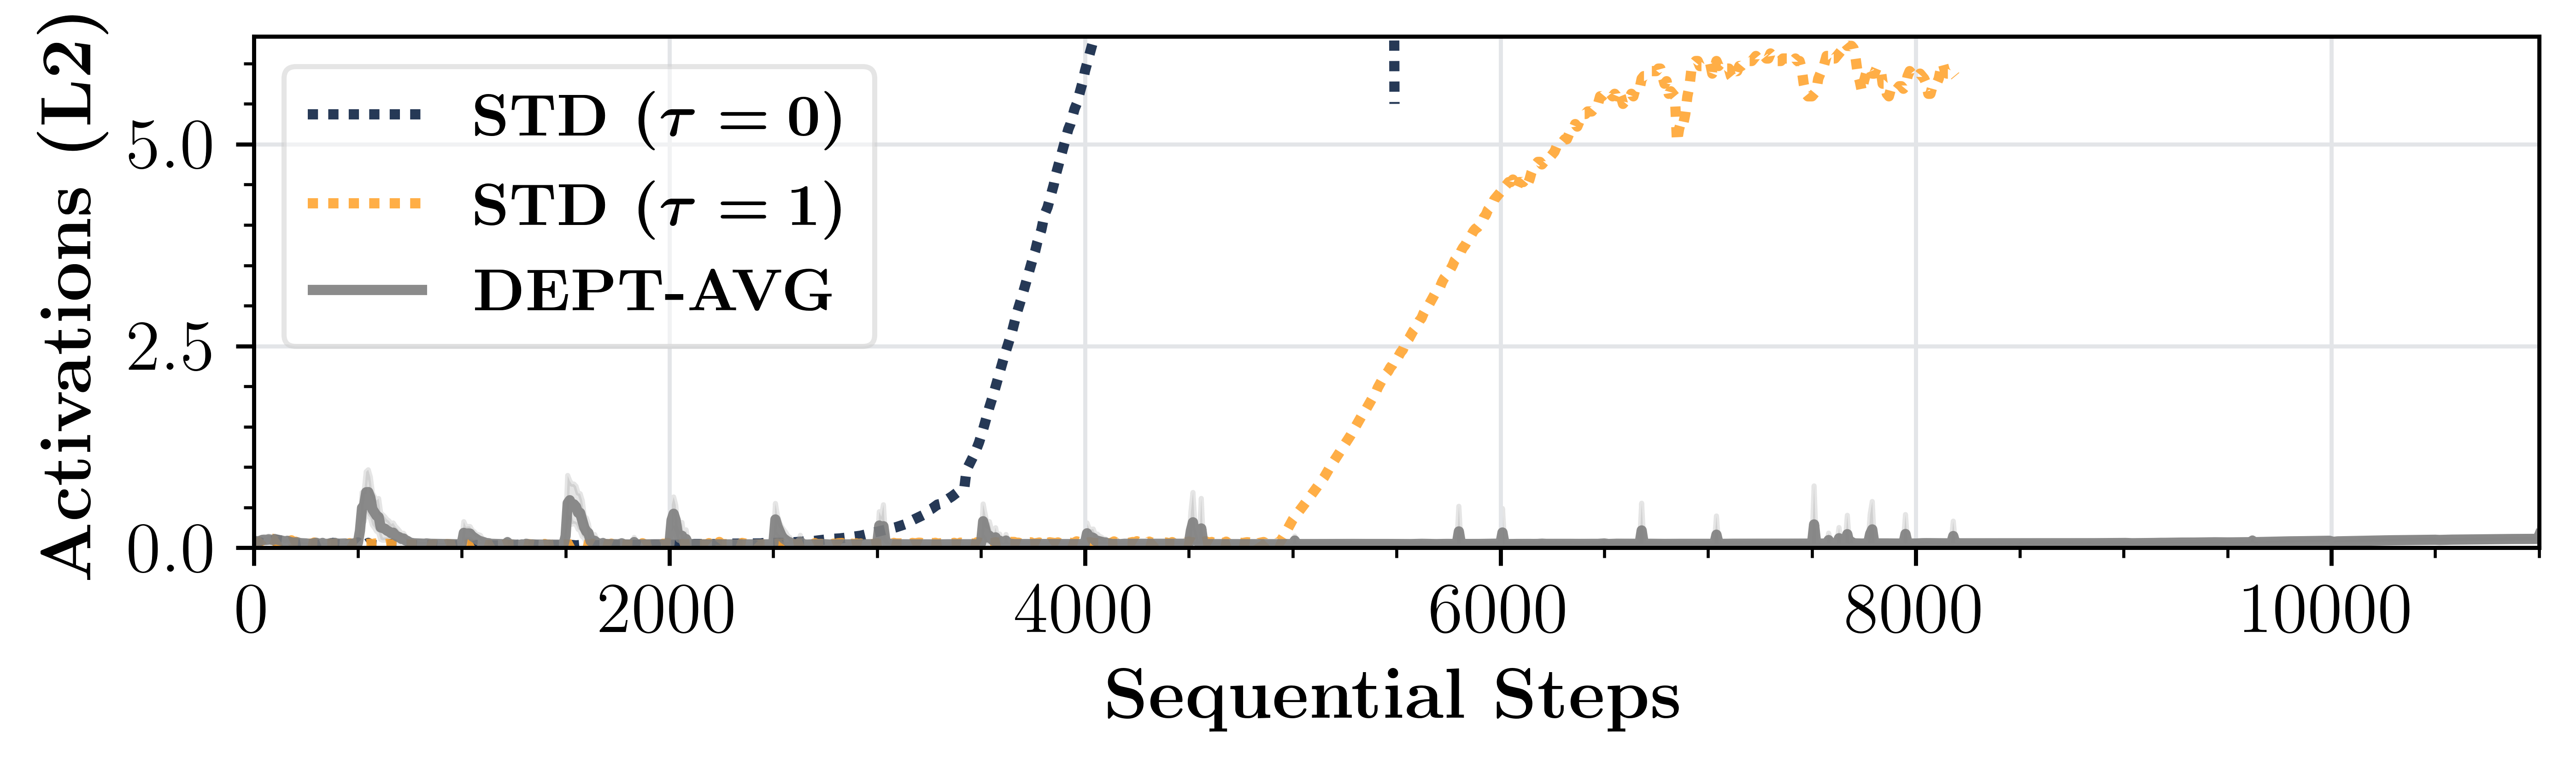

In [51]:
# ---- 350M MCLR ACTIVATIONS---- #


mclr_fed = [
    "mclr_matrix-pile-350M",
    "mclr_full-pile-350M",
    "mclr_pers-350M-p-20240825_232233",
]
mclr_cent = ["mclr_cen-pile-350M-16_balanced", "mclr_cen-pile-350M-16_unbalanced"]
server_df_list: list[pd.DataFrame] = []
clients_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
file_name = "MCLR_PILE_ACT"
x_lim = (0.5, 40)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    for i in range(len(mclr_fed)):
        clients_df_list.append(pd.read_pickle(f"clients_{i}_{df_name}.pkl"))
        server_df_list.append(pd.read_pickle(f"server_{i}_{df_name}.pkl"))
    for i in range(len(mclr_cent)):
        centralized_df_list.append(pd.read_pickle(f"centralized_{i}_{df_name}.pkl"))
except FileNotFoundError:
    for record_name in mclr_cent:
        record = run_id_dict[record_name][0]
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    for i, centralized_df in enumerate(centralized_df_list):
        centralized_df.to_pickle(f"centralized_{i}_{df_name}.pkl")
    for record_name in mclr_fed:
        record = run_id_dict[record_name][0]
        log(INFO, record)
        data_frames = download_metrics(record[0], record[1])
        server_data_frame, clients_data_frame = data_frames[0], data_frames[1]
        server_df_list.append(server_data_frame)
        clients_df_list.append(clients_data_frame)
    for i, client_df in enumerate(clients_df_list):
        client_df.to_pickle(f"clients_{i}_{df_name}.pkl")
    for i, server_df in enumerate(server_df_list):
        server_df.to_pickle(f"server_{i}_{df_name}.pkl")

clients_data_frame = pd.concat(clients_df_list)

plot_federated_runs_activations(
    [clients_data_frame],
    [MethodsNames.DEPT_AVG.value],
    centralized_df_list,
    [MethodsNames.UNIFORM.value, MethodsNames.PROPORTIONAL.value],
    f"{file_name}_act.pdf",
    x_lim=(0, 11000),
    y_lim={"bottom": 0, "top": 4.5},
    figsize=(8, 1.8),
)

plot_federated_runs_l2_norms(
    [clients_data_frame],
    [MethodsNames.DEPT_AVG.value],
    centralized_df_list,
    [MethodsNames.UNIFORM.value, MethodsNames.PROPORTIONAL.value],
    f"{file_name}_l2_norms.pdf",
    x_lim=(0, 11000),
    y_lim={"bottom": 700, "top": 850},
    figsize=(8, 1.8),
)

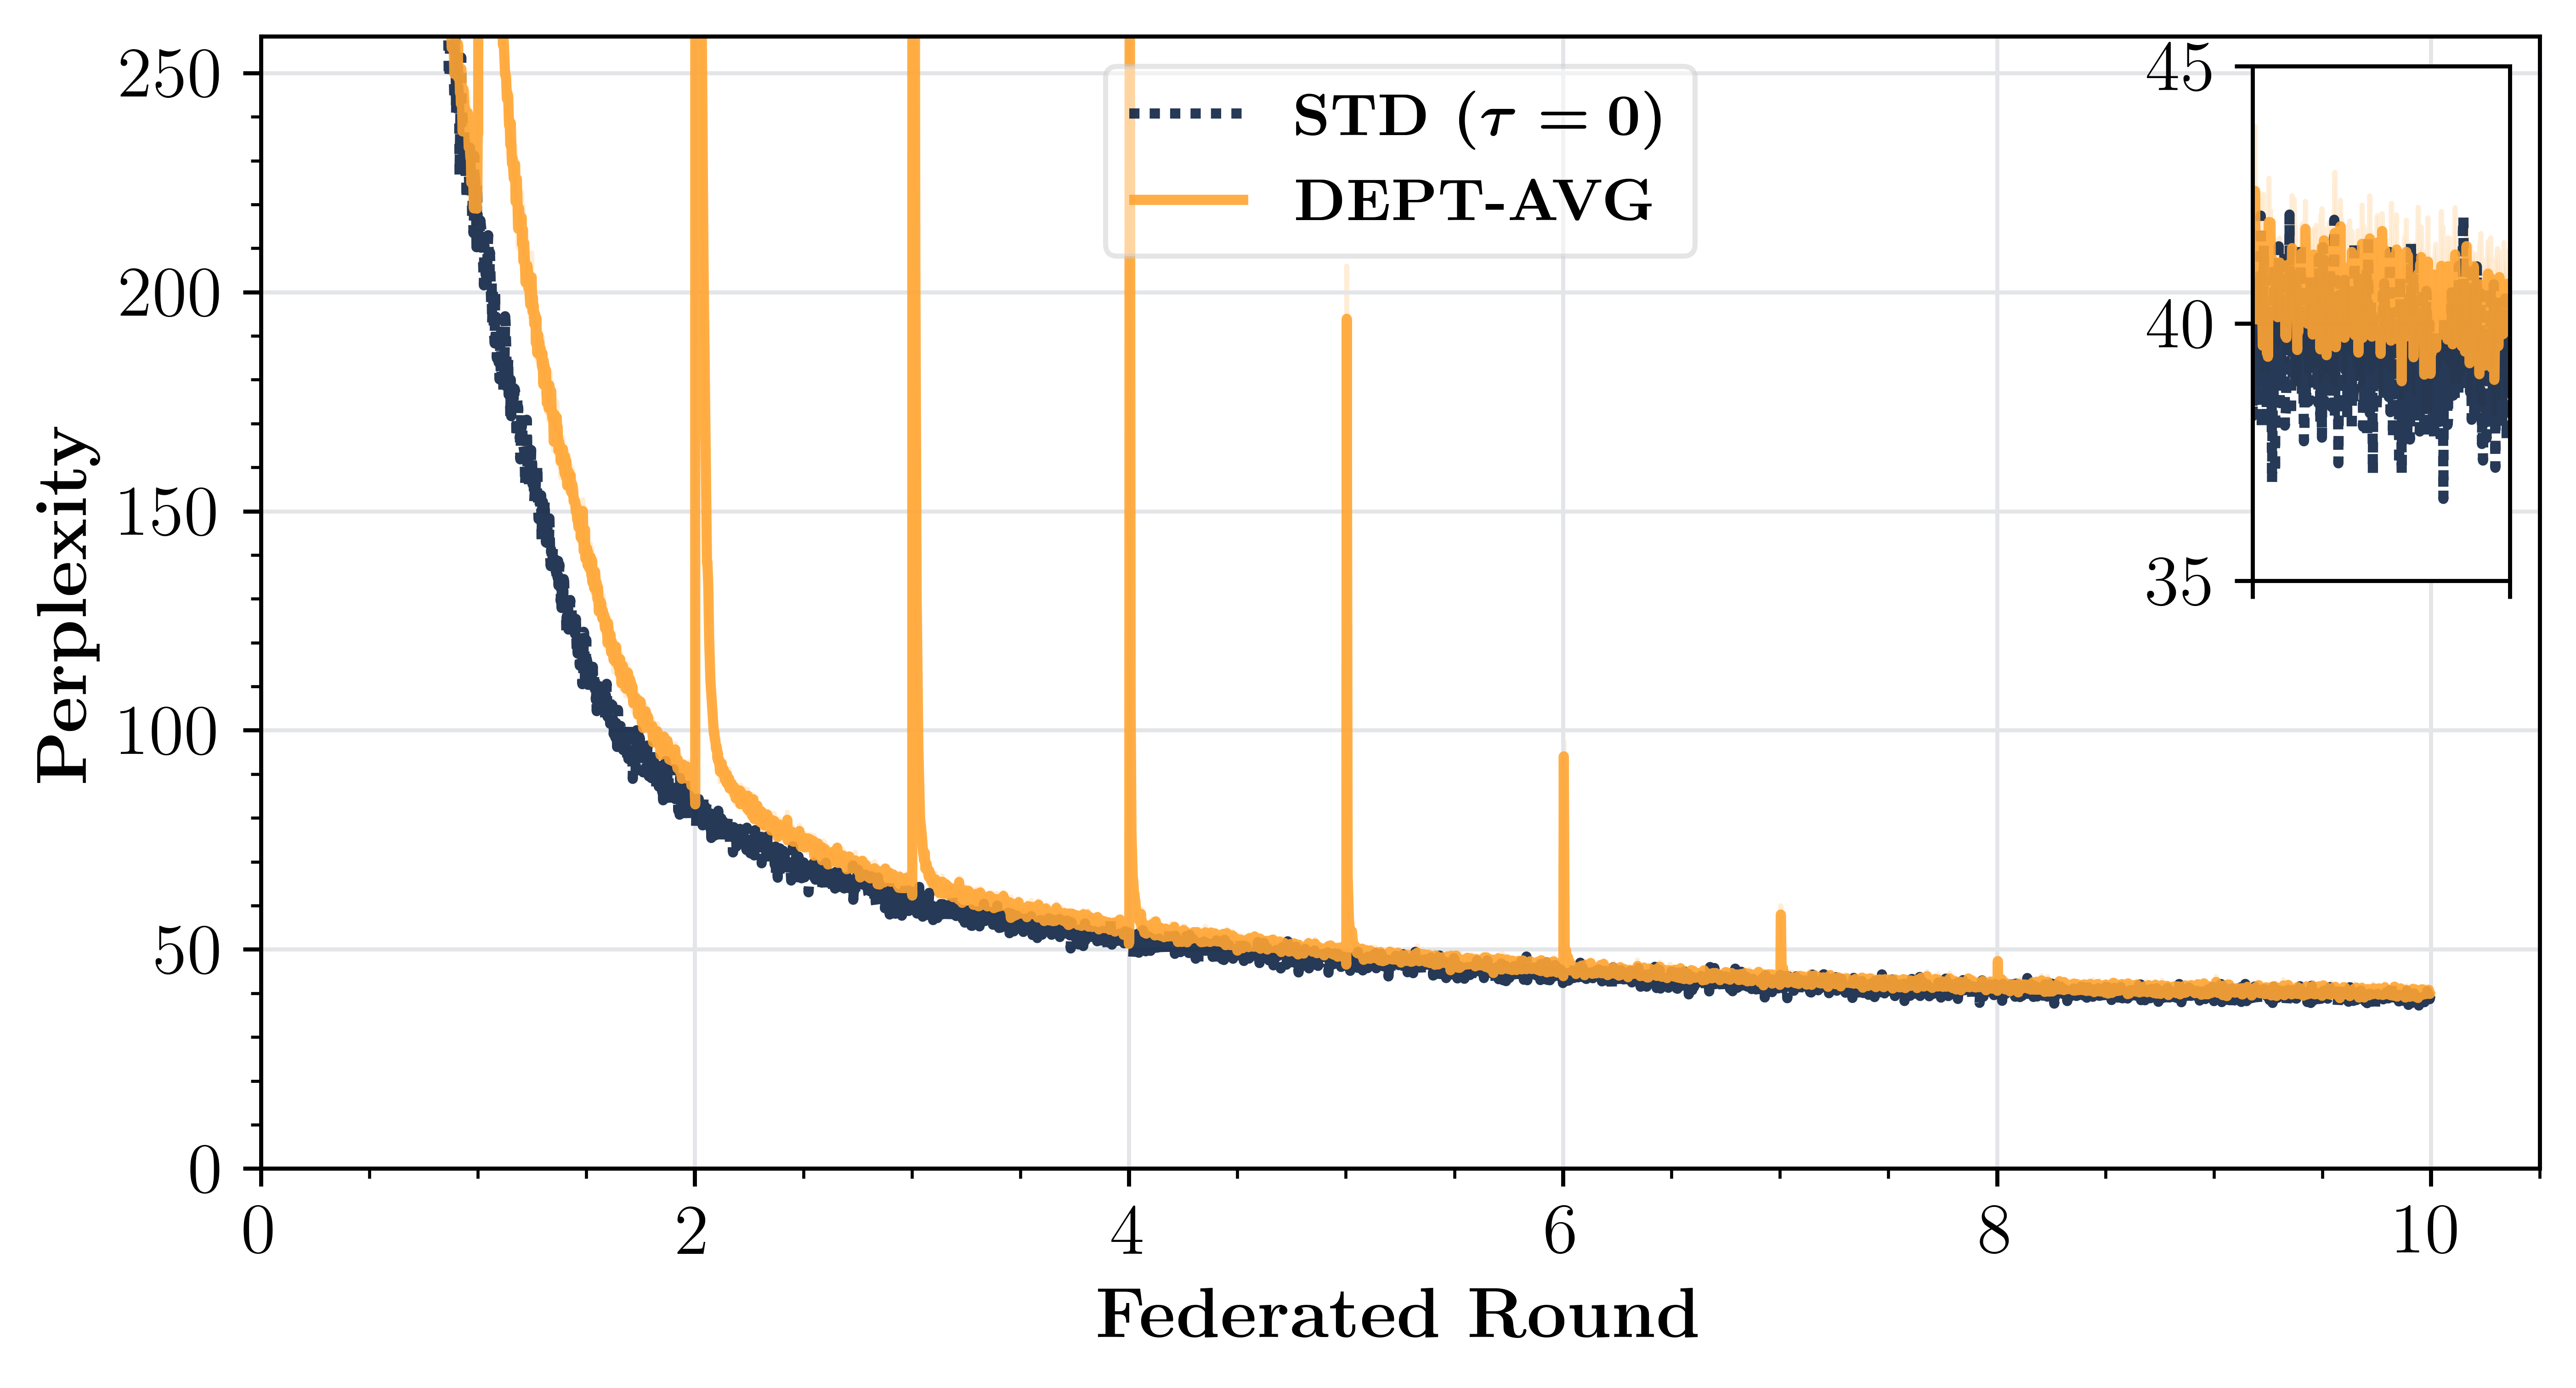

In [52]:
# ----IID data plotting---- #


mclr_fed = ["matrix-125M-20240823-tle", "full-125M-20240823_125915"]
mclr_cent = ["centB-125M-20240907_115804"]
server_df_list: list[pd.DataFrame] = []
clients_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
file_name = "IID_DATA"
x_lim = (0.5, 40)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    client_df = pd.read_pickle("iid_data_clients.pkl")
    server_df = pd.read_pickle("iid_data_server.pkl")
    centralized_df = pd.read_pickle("iid_data_centralized.pkl")
except FileNotFoundError:
    for record_name in mclr_cent:
        record = run_id_dict[record_name][0]
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    centralized_df = pd.concat(centralized_df_list)
    centralized_df.to_pickle("iid_data_centralized.pkl")
    for record_name in mclr_fed:
        data_frames = download_metrics(record_name, 16)
        server_data_frame, clients_data_frame, client_df_list = data_frames
        clients_df_list.append(clients_data_frame)
        server_df_list.append(server_data_frame)
    client_df = pd.concat(clients_df_list)
    server_df = pd.concat(server_df_list)
    client_df.to_pickle("iid_data_clients.pkl")
    server_df.to_pickle("iid_data_server.pkl")

# This crashes because data is missing from the wandb run
# plot_federated_runs_l2_norms(
#     centralized_data_frames=[centralized_df],
#     centralized_data_names=["STANDARD"],
#     clients_data_frames=[client_df],
#     client_data_names=["DEPT-AVG"],
#     file_name=f"{file_name}_l2_norms.pdf",
#     x_lim=(0, 5000),
#     y_lim={"bottom": 700, "top": 850},
#     figsize=(8, 1.8),
# )

plot_perplexities(
    centralized_data_frames=[centralized_df],
    centralized_data_names=[MethodsNames.UNIFORM.value],
    dept_data_frames=[client_df],
    dept_data_names=[MethodsNames.DEPT_AVG.value],
    file_name=f"{file_name}_iid_data_ppl.pdf",
    val=False,
    y_lim={"bottom": 25, "top": 225},
    use_rounds=True,
    x_lim=(0.5, 10),
    legend_kwargs={"loc": PlottingCosmetics.UPPER_CENTER_POS.value},
    box_y_lim={"bottom": 35, "top": 45},
    box_x_lim=(9, 10),
    show_box=True,
)

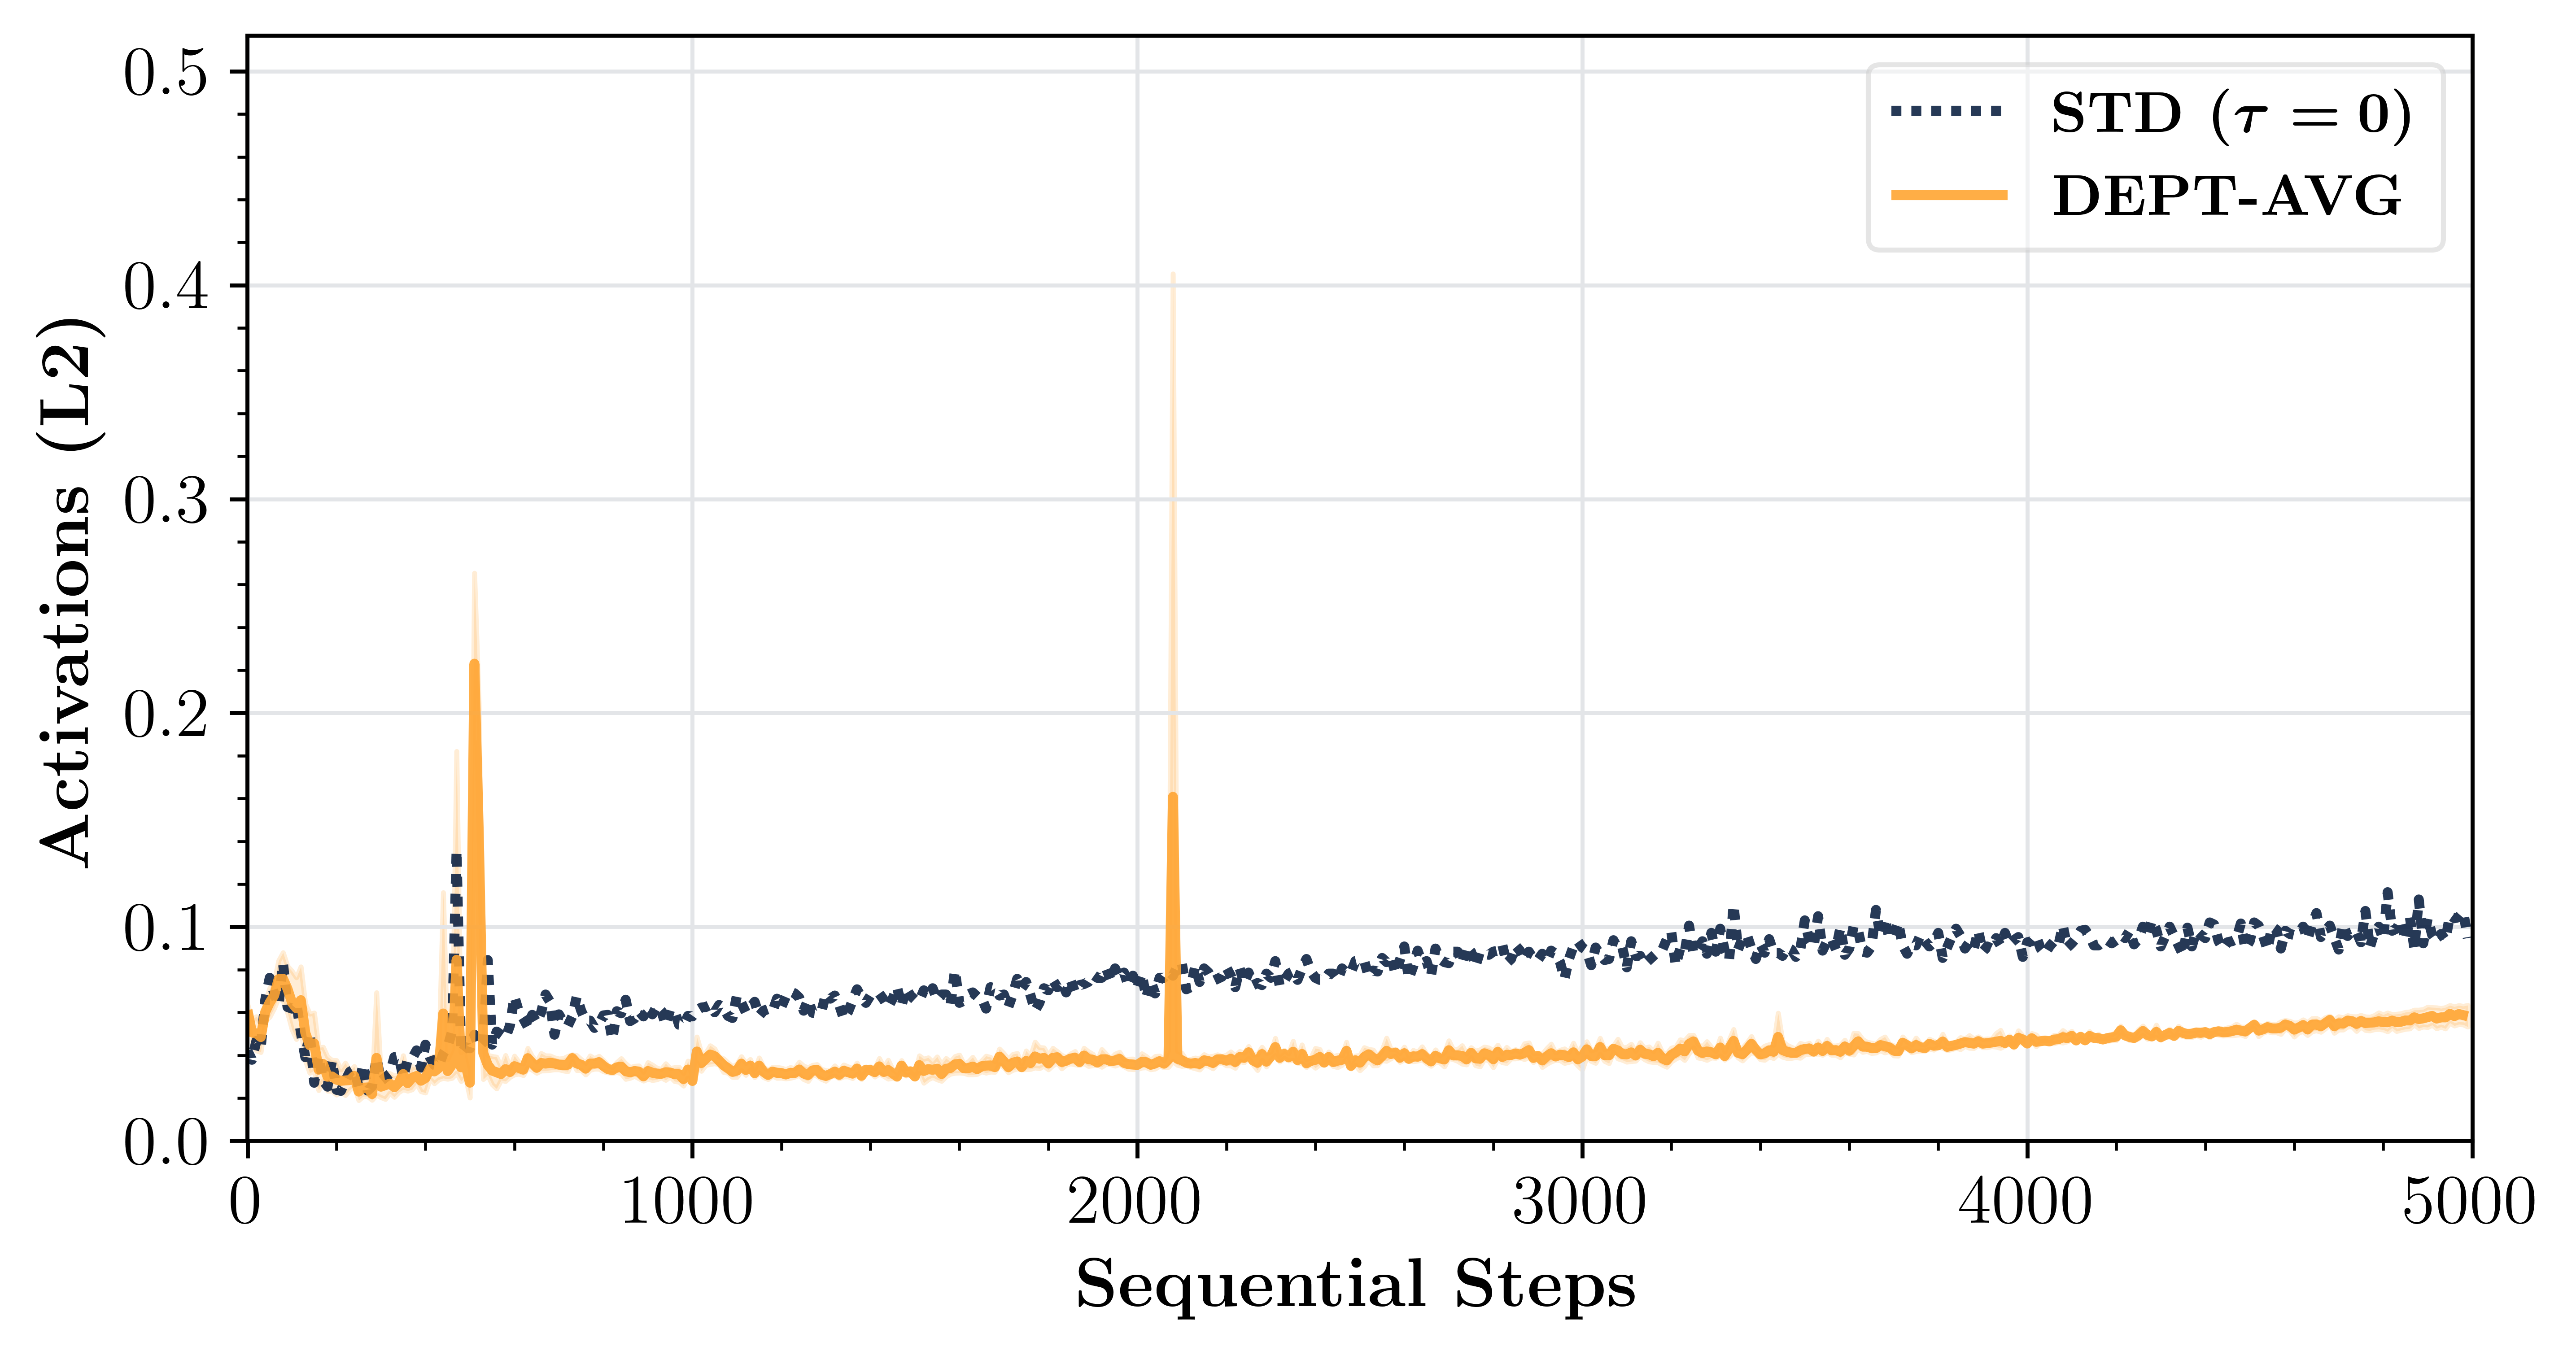

In [53]:
# ----IID data plotting---- #

mclr_fed = ["matrix-125M-20240823-tle", "full-125M-20240823_125915"]
mclr_cent = ["centB-125M-20240907_115804"]
server_df_list: list[pd.DataFrame] = []
clients_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
file_name = "IID_DATA"
x_lim = (0.5, 40)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    client_df = pd.read_pickle("iid_data_clients.pkl")
    server_df = pd.read_pickle("iid_data_server.pkl")
    centralized_df = pd.read_pickle("iid_data_centralized.pkl")
except FileNotFoundError:
    for record_name in mclr_cent:
        record = run_id_dict[record_name][0]
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    centralized_df = pd.concat(centralized_df_list)
    centralized_df.to_pickle("iid_data_centralized.pkl")
    for record_name in mclr_fed:
        data_frames = download_metrics(record_name, 16)
        server_data_frame, clients_data_frame, client_df_list = data_frames
        clients_df_list.append(clients_data_frame)
        server_df_list.append(server_data_frame)
    client_df = pd.concat(clients_df_list)
    server_df = pd.concat(server_df_list)
    client_df.to_pickle("iid_data_clients.pkl")
    server_df.to_pickle("iid_data_server.pkl")

plot_federated_runs_activations(
    centralized_data_frames=[centralized_df],
    centralized_data_names=[MethodsNames.UNIFORM.value],
    clients_data_frames=[client_df],
    client_data_names=[MethodsNames.DEPT_AVG.value],
    file_name=f"{file_name}_act.pdf",
    x_lim=(0, 5000),
    y_lim={"bottom": 0, "top": 0.5},
    figsize=(8, 4),
)

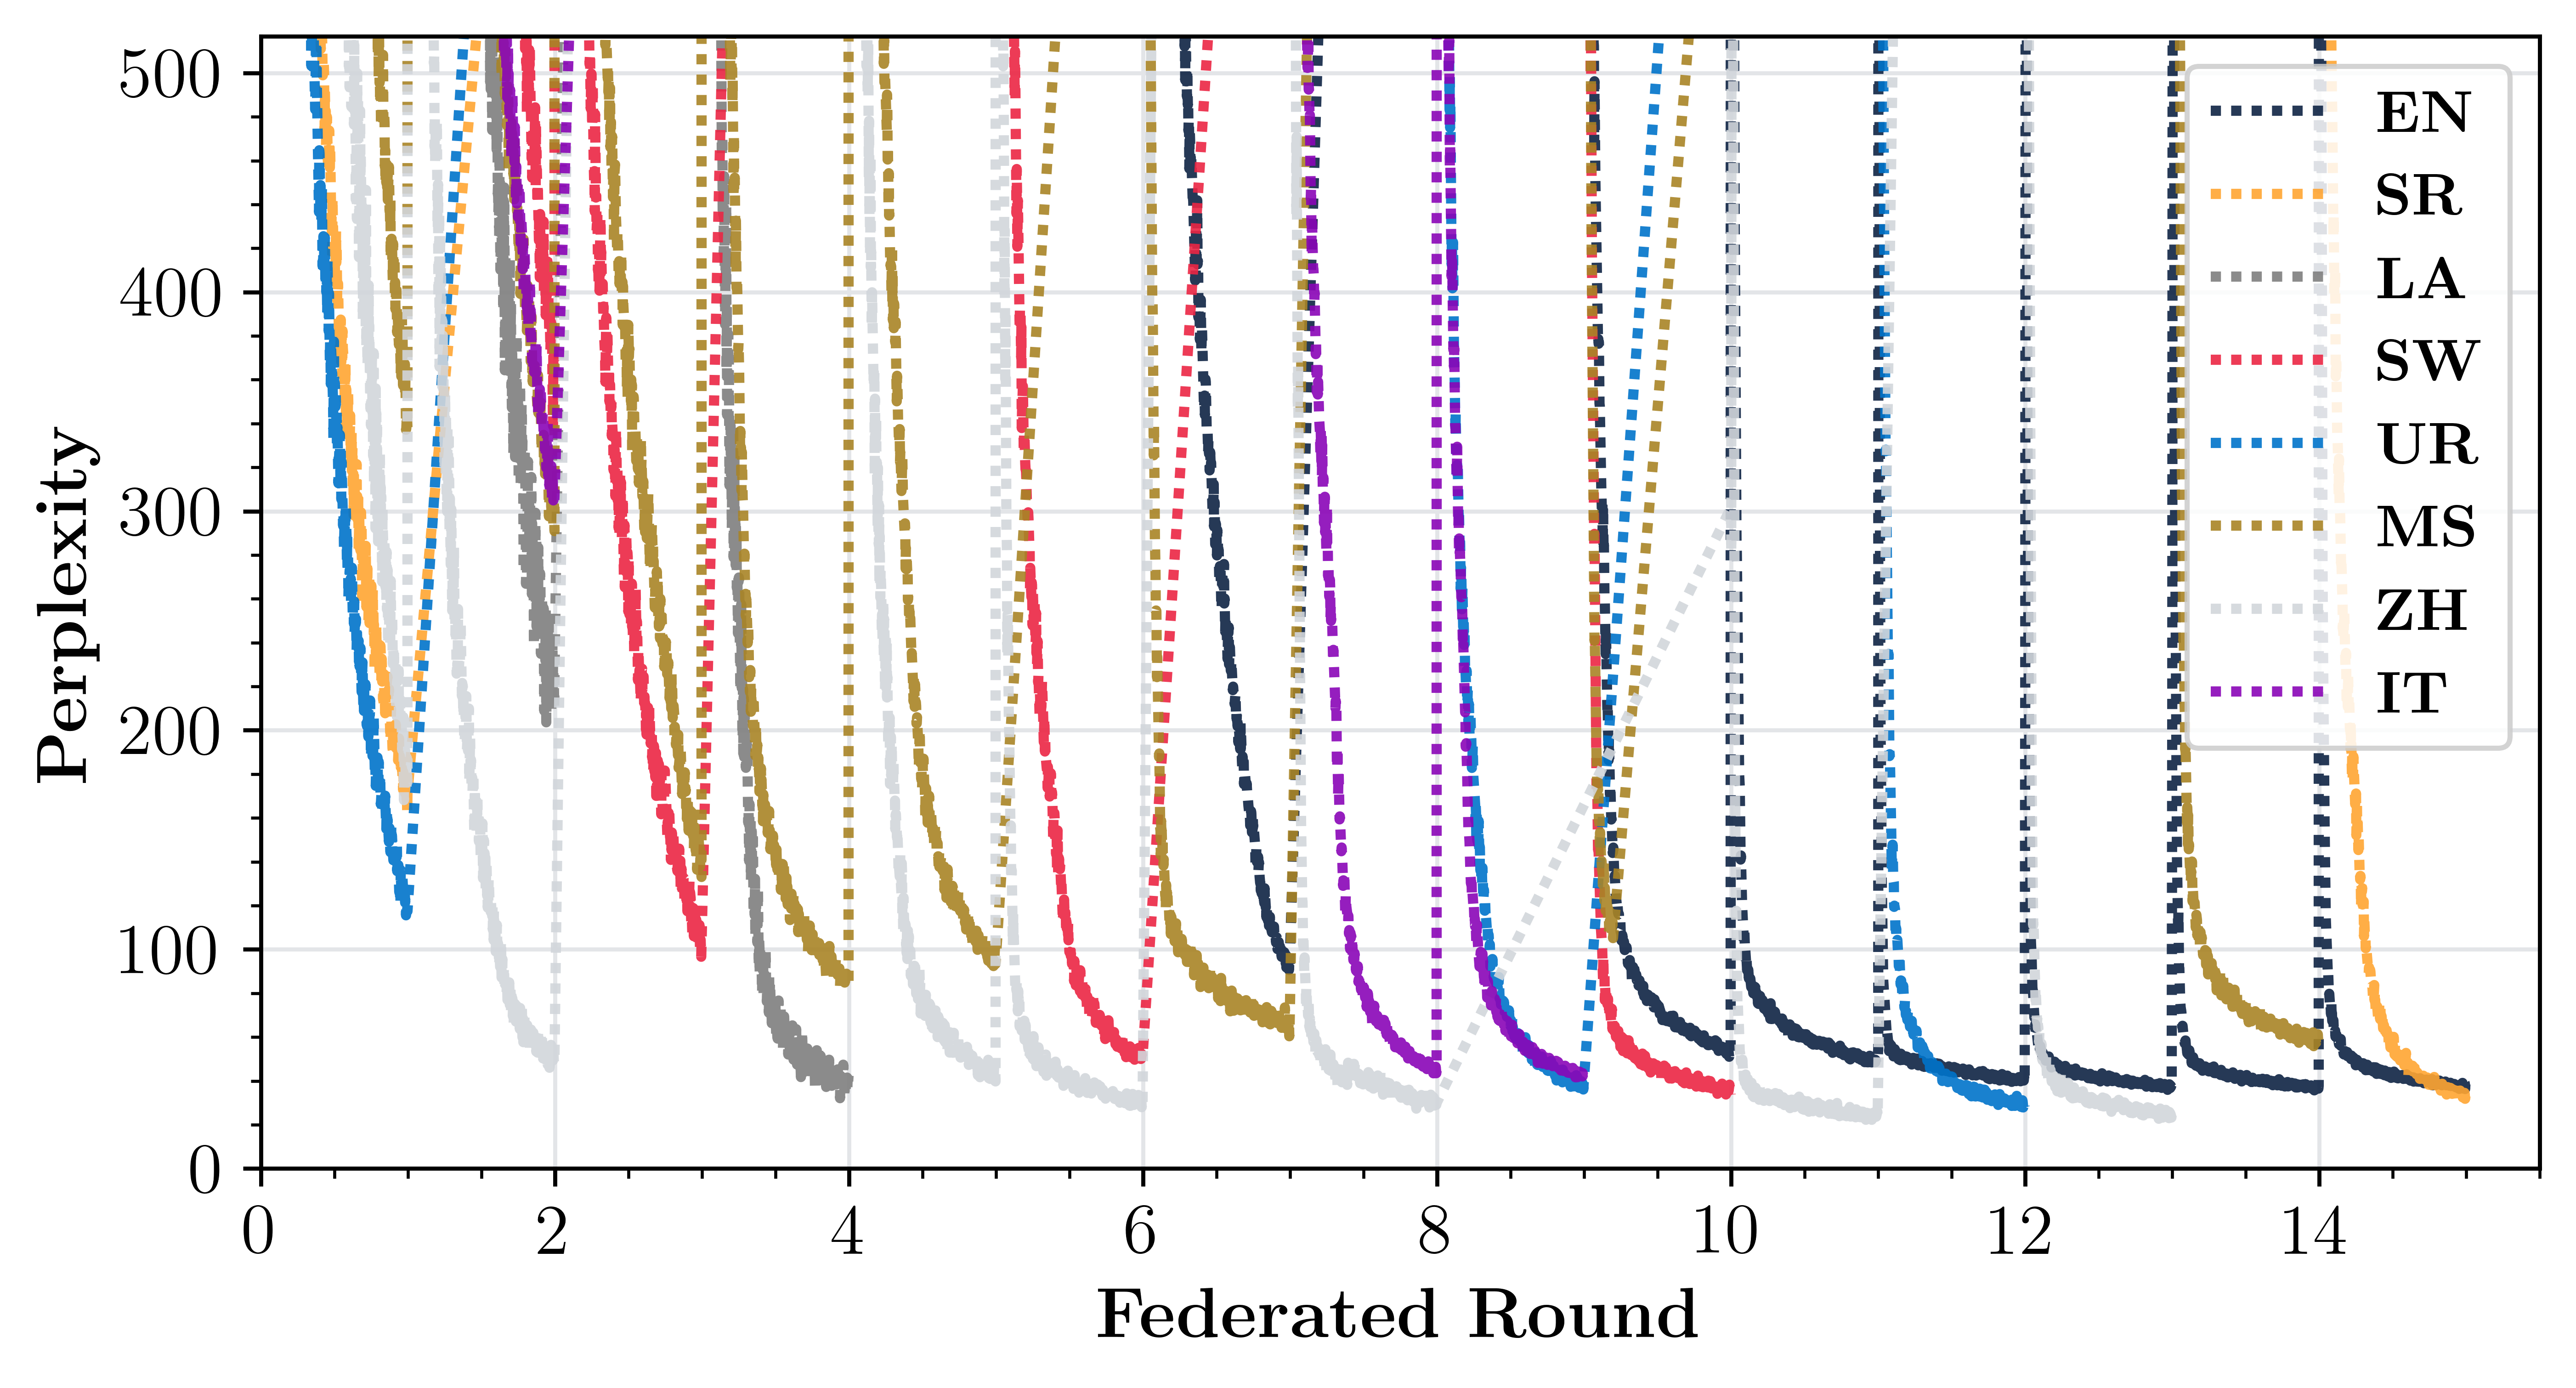

In [54]:
# ----1B plotting---- #


mclr_fed = ["fed-1B-mc4-U"]
mclr_cent = []
server_df_list: list[pd.DataFrame] = []
clients_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
centralized_df_list: list[pd.DataFrame] = []
file_name = "BIG_MODEL"
x_lim = (0.5, 40)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    for i in range(len(mclr_fed)):
        clients_df_list.append(pd.read_pickle(f"big_model_clients_{i}_{df_name}.pkl"))
        server_df_list.append(pd.read_pickle(f"big_model_server_{i}_{df_name}.pkl"))
    for i in range(len(mclr_cent)):
        centralized_df_list.append(
            pd.read_pickle(f"big_model_centralized_{i}_{df_name}.pkl")
        )
except FileNotFoundError:
    for record_name in mclr_cent:
        record = run_id_dict[record_name][0]
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    for i, centralized_df in enumerate(centralized_df_list):
        centralized_df.to_pickle(f"centralized_{i}_{df_name}.pkl")
    for record_name in mclr_fed:
        data_frames = download_metrics(record_name, 8)
        server_data_frame, clients_data_frame, client_df_list = data_frames
    for i, client_df in enumerate(clients_df_list):
        client_df.to_pickle(f"big_model_clients_{i}_{df_name}.pkl")
    for i, server_df in enumerate(server_df_list):
        server_df.to_pickle(f"big_model_server_{i}_{df_name}.pkl")

plot_perplexities(
    centralized_data_frames=client_df_list,
    centralized_data_names=[
        r"\textbf{EN}",
        r"\textbf{SR}",
        r"\textbf{LA}",
        r"\textbf{SW}",
        r"\textbf{UR}",
        r"\textbf{MS}",
        r"\textbf{ZH}",
        r"\textbf{IT}",
    ],
    dept_data_frames=[],
    dept_data_names=[],
    file_name=f"{file_name}_big_model_ppl.pdf",
    val=False,
    y_lim={"bottom": 0, "top": 500},
    use_rounds=True,
    x_lim=(0.5, 15),
    legend_kwargs={
        "framealpha": 0.85,
    },
    show_box=False,
)

In [55]:
# ---- 125 MC4 Balanced Adaptation---- #


mclr_cent = [
    "GF-centT03-125M-mc4-20240918",
    "GF-centUB-125M-mc4-20240918",
    "GFr4-act500-125M-mc4",
    "GFr10_full-125M-mc4-20240912-tle",
    "GFr10-matrix-125M-mc4",
    "GFr8-pers-125M-mc4",
]


centralized_df_list: list[pd.DataFrame] = []
file_name = "DEPT_IMPROVE"
x_lim = (0, 1200)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    for i in range(len(mclr_cent)):
        centralized_df_list.append(pd.read_pickle(f"centralized_{i}_{df_name}.pkl"))
except FileNotFoundError:
    for record_name in mclr_cent:
        record = (record_name, "_client_0")
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    for i, centralized_df in enumerate(centralized_df_list):
        centralized_df.to_pickle(f"centralized_{i}_{df_name}.pkl")

final_dfs = centralized_df_list[:4]
concat_df = pd.concat(centralized_df_list[4:])


plot_perplexities(
    centralized_data_frames=final_dfs[1:],
    centralized_data_names=[
        MethodsNames.TEMPERATURE_0_3.value,
        MethodsNames.PROPORTIONAL.value,
        MethodsNames.ACT.value,
    ],
    dept_data_frames=[concat_df],
    dept_data_names=[MethodsNames.DEPT_AVG.value],
    file_name=f"{file_name}_125M_MC4-B_ppl.pdf",
    val=False,
    y_lim={"bottom": 25, "top": 200},
    figsize=(8, 3),
    x_lim=(0, 1200),
    legend_kwargs={"loc": PlottingCosmetics.UPPER_CENTER_POS},
    box_y_lim={"bottom": 40, "top": 60},
    box_x_lim=(1150, 1200),
)

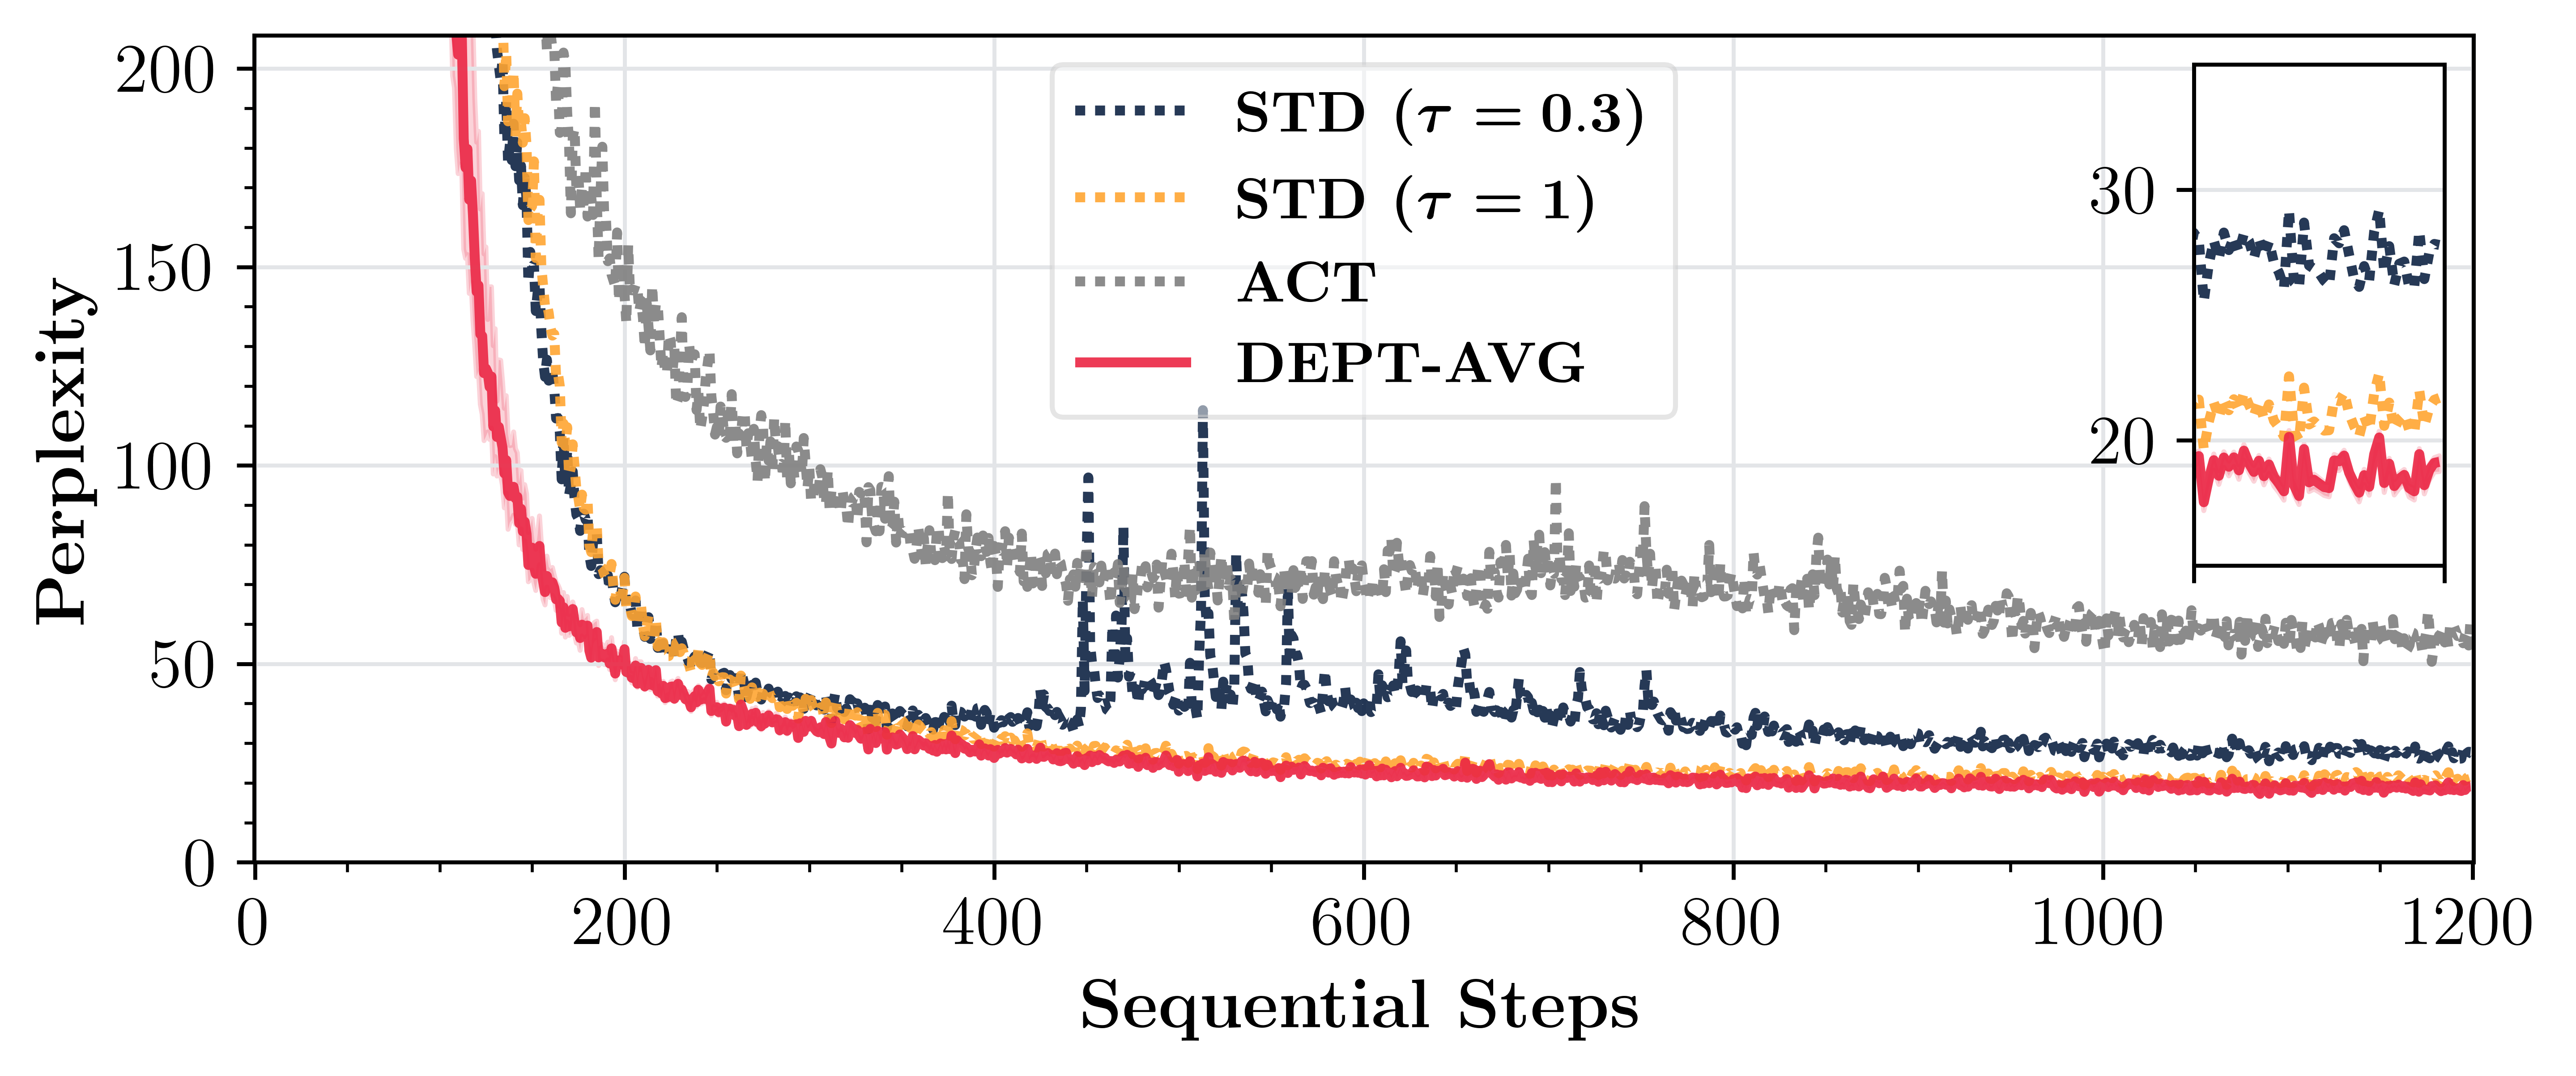

In [56]:
# ---- 125 MC4 SW Adaptation---- #


mclr_cent = [
    "GS-centT03-125M-mc4-20240918",
    "GS-centUB-125M-mc4-20240918",
    "GFr4-act500-125M-mc4",
    "GSr10_full-125M-mc4-20240912-tle",
    "GSr10-matrix-125M-mc4",
    "GSr8-pers-125M-mc4",
]


centralized_df_list: list[pd.DataFrame] = []
file_name = "DEPT_IMPROVE_SW"
x_lim = (0, 1200)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    for i in range(len(mclr_cent)):
        centralized_df_list.append(pd.read_pickle(f"centralized_{i}_{df_name}.pkl"))
except FileNotFoundError:
    for record_name in mclr_cent:
        record = (record_name, "_client_0")
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    for i, centralized_df in enumerate(centralized_df_list):
        centralized_df.to_pickle(f"centralized_{i}_{df_name}.pkl")

final_dfs = centralized_df_list[:3]
concat_df = pd.concat(centralized_df_list[3:])


plot_perplexities(
    centralized_data_frames=final_dfs,
    centralized_data_names=[
        MethodsNames.TEMPERATURE_0_3.value,
        MethodsNames.PROPORTIONAL.value,
        MethodsNames.ACT.value,
    ],
    dept_data_frames=[concat_df],
    dept_data_names=[MethodsNames.DEPT_AVG.value],
    file_name=f"{file_name}_125M_MC4-SW_ppl.pdf",
    val=False,
    y_lim={"bottom": 0, "top": 200},
    figsize=(8, 3),
    x_lim=(0, 1200),
    legend_kwargs={"loc": PlottingCosmetics.UPPER_CENTER_POS},
    box_y_lim={"bottom": 15, "top": 35},
    box_x_lim=(1150, 1200),
)

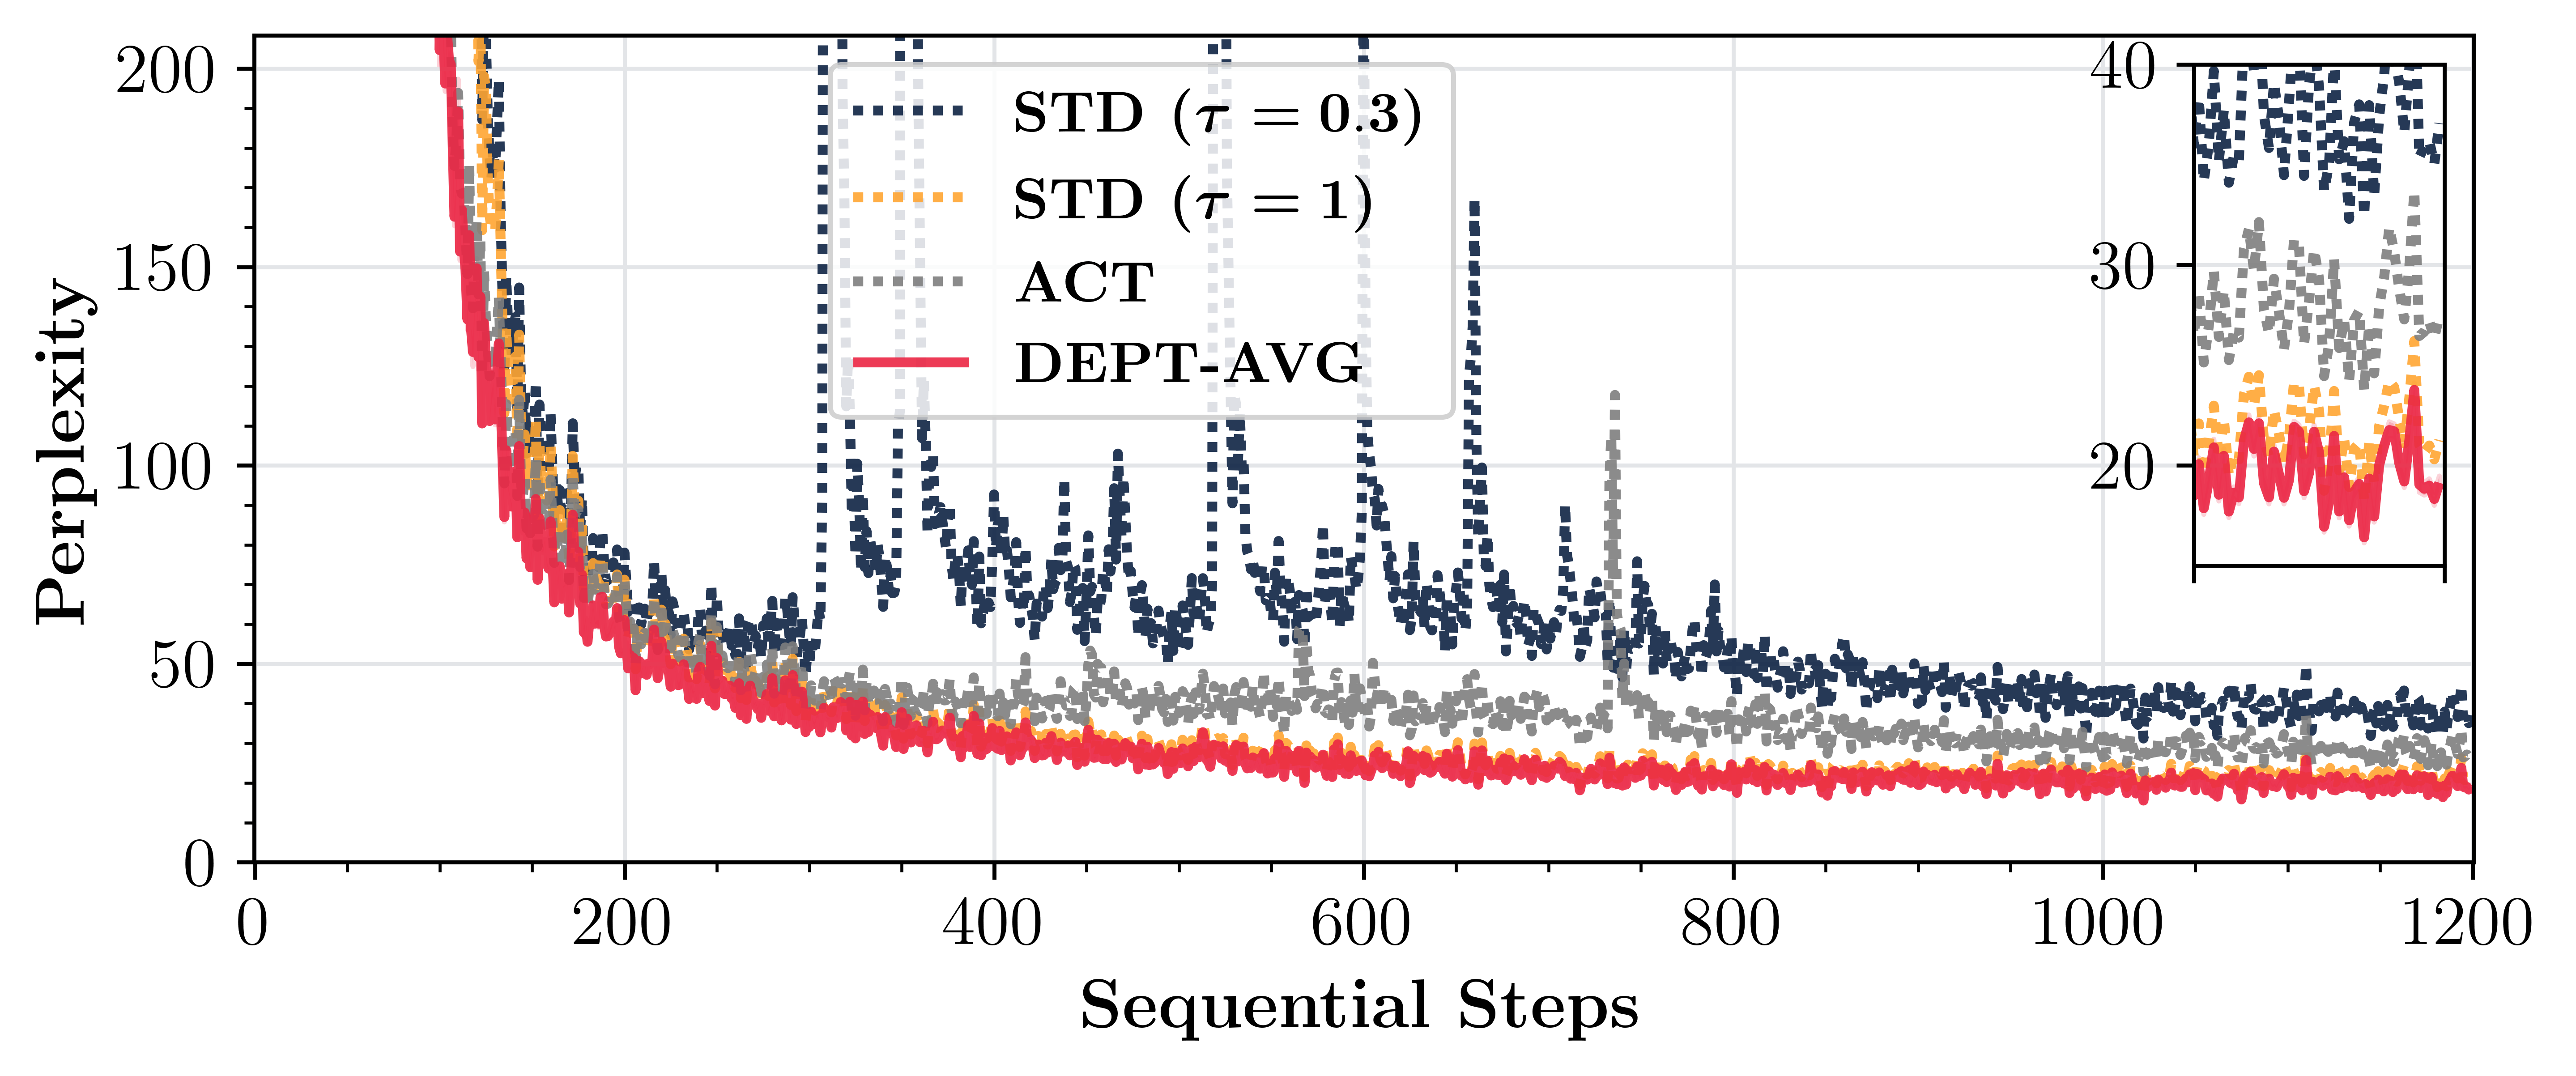

In [57]:
# ---- 125 MC4 HI Adaptation---- #

mclr_cent = [
    "GHI-centT03-125M-mc4-20240918",
    "GHI-centUB-125M-mc4-20240918",
    "GHI4-act500-125M-mc4",
    "GHIr10_full-125M-mc4-20240912-tle",
    "GHIr8-pers-125M-mc4",
]


centralized_df_list: list[pd.DataFrame] = []
file_name = "DEPT_IMPROVE_HI"
x_lim = (0, 1200)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    for i in range(len(mclr_cent)):
        centralized_df_list.append(pd.read_pickle(f"centralized_{i}_{df_name}.pkl"))
except FileNotFoundError:
    for record_name in mclr_cent:
        record = (record_name, "_client_0")
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    for i, centralized_df in enumerate(centralized_df_list):
        centralized_df.to_pickle(f"centralized_{i}_{df_name}.pkl")

final_dfs = centralized_df_list[:3]
concat_df = pd.concat(centralized_df_list[3:])


plot_perplexities(
    centralized_data_frames=final_dfs,
    centralized_data_names=[
        MethodsNames.TEMPERATURE_0_3.value,
        MethodsNames.PROPORTIONAL.value,
        MethodsNames.ACT.value,
    ],
    dept_data_frames=[concat_df],
    dept_data_names=[MethodsNames.DEPT_AVG.value],
    file_name=f"{file_name}_125M_MC4-HI_ppl.pdf",
    val=False,
    y_lim={"bottom": 0, "top": 200},
    figsize=(8, 3),
    x_lim=(0, 1200),
    legend_kwargs={
        "loc": PlottingCosmetics.UPPER_CENTER_POS,
        "bbox_to_anchor": (0.4, 1.0),
        "framealpha": 0.85,
    },
    box_y_lim={"bottom": 15, "top": 40},
    box_x_lim=(1150, 1200),
)

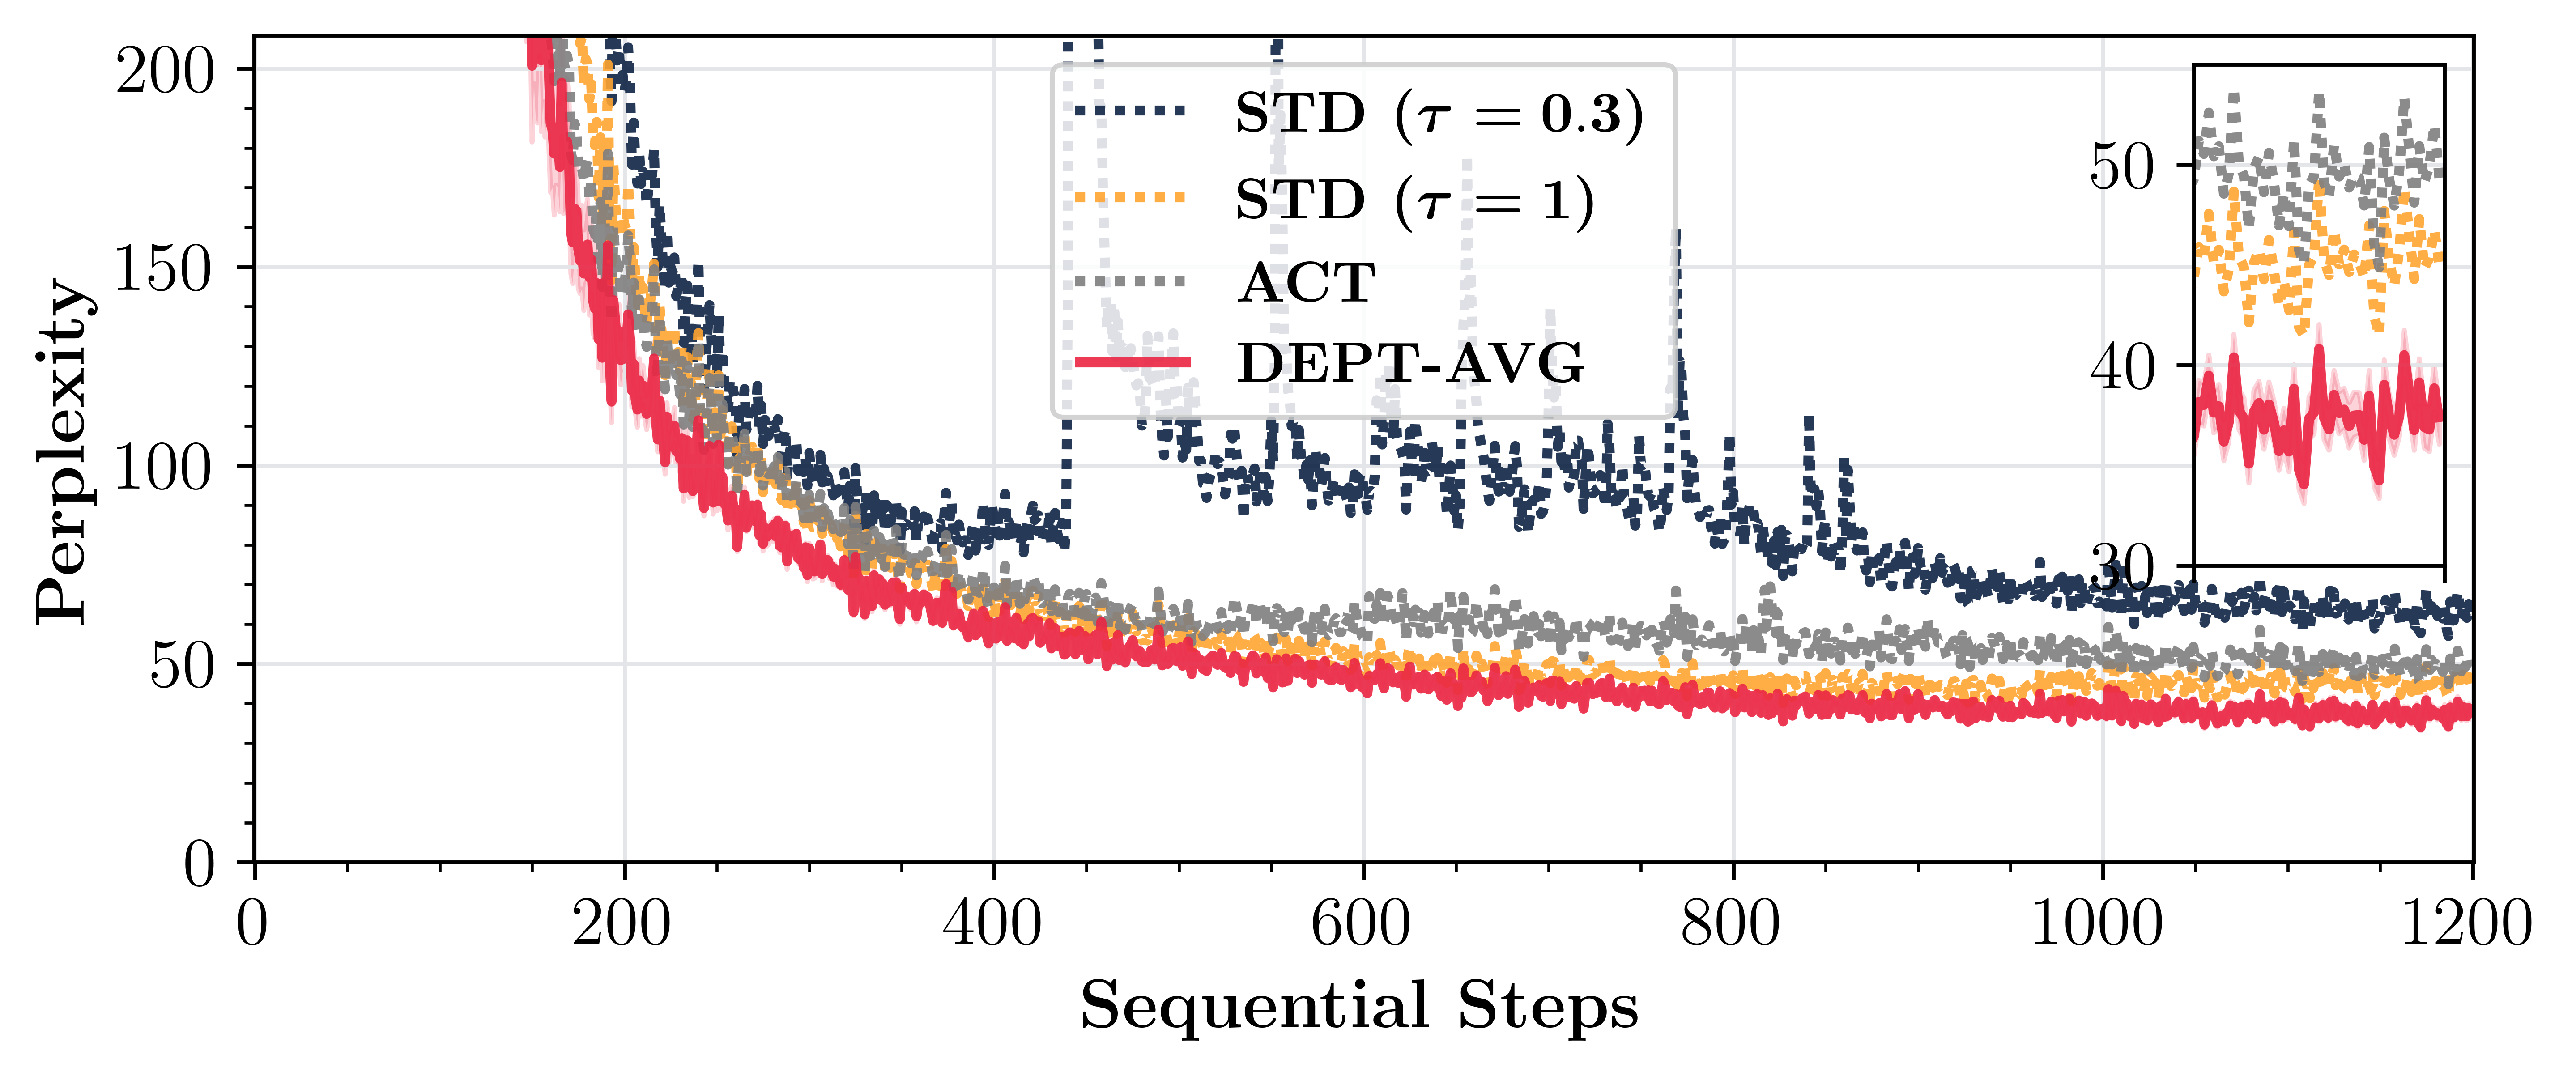

In [58]:
# ---- 125 DE Balanced Adaptation---- #

mclr_cent = [
    "GDE-centT03-125M-mc4-20240918",
    "GDE-centUB-125M-mc4-20240918",
    "GDE4-act500-125M-mc4",
    "GDEr10-matrix-125M-mc4",
    "GDEr10_full-125M-mc4-20240912-tle",
    "GDEr8-pers-125M-mc4",
]

centralized_df_list: list[pd.DataFrame] = []
file_name = "DEPT_IMPROVE_DE"
x_lim = (0, 1200)
perplexity_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
l2_gradient_legend_kwargs = {"loc": PlottingCosmetics.UPPER_RIGHT_POS.value}
df_name = file_name.replace(".pdf", "_df")
try:
    for i in range(len(mclr_cent)):
        centralized_df_list.append(pd.read_pickle(f"centralized_{i}_{df_name}.pkl"))
except FileNotFoundError:
    for record_name in mclr_cent:
        record = (record_name, "_client_0")
        log(INFO, record)
        data_frames = download_metrics_centralized(*record)
        centralized_df_list.append(data_frames)
    for i, centralized_df in enumerate(centralized_df_list):
        centralized_df.to_pickle(f"centralized_{i}_{df_name}.pkl")

final_dfs = centralized_df_list[:3]
concat_df = pd.concat(centralized_df_list[3:])


plot_perplexities(
    centralized_data_frames=final_dfs,
    centralized_data_names=[
        MethodsNames.TEMPERATURE_0_3.value,
        MethodsNames.PROPORTIONAL.value,
        MethodsNames.ACT.value,
    ],
    dept_data_frames=[concat_df],
    dept_data_names=[MethodsNames.DEPT_AVG.value],
    file_name=f"{file_name}_125M_MC4-DE_ppl.pdf",
    val=False,
    y_lim={"bottom": 25, "top": 200},
    figsize=(8, 3),
    x_lim=(0, 1200),
    legend_kwargs={
        "loc": PlottingCosmetics.UPPER_CENTER_POS,
        "framealpha": 0.85,
    },
    box_y_lim={"bottom": 30, "top": 55},
    box_x_lim=(1150, 1200),
)